**Alternative Implementation**

**Advantages**:

* Can be parallelised _unlinke_ MD trajectory analysis (u.trajectory)
* Overall time per trajectory 15 secs (9 secs traj loading + 6 secs data analysis)

**Caveats**:

* Requires frame extraction, which requires time. However, already paralelised (Use  `~/mpmodeling/tools/protein_frame_extractor.py`)
* Increased storage 

**SECOND**: Re-do frame extraction for increase sampling 
```bash
nohup python parallel_protein_extraction_urmd.py 20 EMMD_Sample.json > parallel_protein_extraction_urmd.out &
```

# Overview

**Main profiles to compare**

* Isambard-based VdW profiles (own method)
* HOLE hydrodynamic profiles (suspected to overestimate length)

**Objective**
Determine difference between profiles for pore minimum radius and lenght dimensions

**Datasets**

* All conformation-classified docked structures
* Conformaion-classified docked structures from Sample for MD
* Protein frames from First 10ns of MD (Sample)
* Protein frames from Last 10ns of MD (Sample)

# Define Datasets

In [1]:
import os
import json
import numpy
import pandas
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
wd = '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/md_relax/'

## All conformation-classified docked structures

In [3]:
MUTANTS = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

CONFORMATIONS = {
    'cWza':['conformation0', 'conformation1'],
    'cWza-K375C':['conformation0', 'conformation1'],
    'cWza-S355C':['conformation0', 'conformation1'],
    'cWza-Y373C':['conformation1'],
}

param_list = []
for i in range(len(MUTANTS)):
    mutant = MUTANTS[i]
    for C in CONFORMATIONS[mutant]:
        mutant_dir = mutant+'/'+C 
        for model_dir in [mutant_dir+'/'+model for model in os.listdir(wd+mutant_dir)]:
            model_name = model_dir.split('/')[-1]
            model_pdb = wd+model_dir+'/'+model_name+'.pdb'
            param_list.append(model_pdb)

## Conformation-classified docked structures from Sample for MD

In [ ]:
with open(wd+'EMMD_Sample.json','r') as fp:
    Sample = json.load(fp)
fp.close()

Sample = list(set(Sample))
    
for i in range(len(Sample)):
    model_dir = Sample[i]
    model_name = model_dir.split('/')[-1]
    model_pdb = wd+model_dir+'/'+model_name+'.pdb'
    param_list.append(model_pdb)

## Protein frames from First 10ns of MD (Sample)

In [36]:
import json

with open(wd+'EMMD_Sample.json','r') as fp:
    Sample = json.load(fp)
fp.close()

Sample = list(set(Sample))

frame_init = 0 # 0 ns
frame_final = 100 # 10 ns

param_list = []
for i in range(len(Sample)):
    model_dir = Sample[i]
    model_name = model_dir.split('/')[-1]
    frames_dir = wd+model_dir+'/complex/mdf/md_100ns/'
    if os.path.isdir(frames_dir) and len(os.listdir(frames_dir))>900:
        for j in range(frame_init, frame_final):
            model_pdb = frames_dir+'Protein_'+str(j)+'.pdb'
            param_list.append(model_pdb)

In [38]:
with open(wd+"param_list_metrics_First10ns.json","w") as fp:
    json.dump(param_list,fp,indent=4)
fp.close()

## Protein frames from Last 10ns of MD (Sample)

In [ ]:
import json

with open(wd+'EMMD_Sample.json','r') as fp:
    Sample = json.load(fp)
fp.close()    

Sample = list(set(Sample))

frame_init = 900 # 0 ns
frame_final = 1000 # 10 ns

param_list = []
for i in range(len(Sample)):
    model_dir = Sample[i]
    model_name = model_dir.split('/')[-1]
    frames_dir = wd+model_dir+'/complex/mdf/md_100ns/'
    if os.path.isdir(frames_dir) and len(os.listdir(frames_dir))>900:
        for j in range(frame_init, frame_final):
            model_pdb = frames_dir+'Protein_'+str(j)+'.pdb'
            param_list.append(model_pdb)

# Frame extraction for MD simulated models

## Completed/remaining simulations

In [ ]:
import os
import json
import numpy

In [ ]:
wd = '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/md_relax/'

In [ ]:
with open(wd+'EMMD_Sample.json','r') as fp:
    Sample = json.load(fp)
fp.close()

Sample = list(set(Sample)) #  Remove redundancies in sample

In [ ]:
name = 'md_100ns' # Simulation name
file_types = ['.gro','.tpr','.xtc'] # File extensions
dir_prefix = '/complex/mdf/'

check_files_exist = lambda files : all(map(os.path.isfile, files))
files_exist = [check_files_exist([wd+model_dir+dir_prefix+name+t for t in file_types]) for model_dir in Sample]

In [ ]:
# Filtre out models
completed_simulations = lambda state : list(numpy.array(Sample)[numpy.array(files_exist)== state])
models_completed = completed_simulations(True)
models_remaining = completed_simulations(False)

In [ ]:
models_remaining

In [ ]:
len(models_completed), len(models_remaining), len(Sample)

## Models requiring frame extractions

In [ ]:
import glob

dir_current = os.getcwd()
n_frames_target = 1000

models_incomplete_frames = []
models_complete_frames = []

for model_dir in models_completed:
    dir_check = wd+model_dir+dir_prefix+name
    regex = "Protein_*.pdb"

    os.chdir(dir_check)
    frames_pdb = glob.glob(regex)
    os.chdir(dir_current)
    
    if len(frames_pdb) < n_frames_target:
        print(model_dir, len(frames_pdb))
        models_incomplete_frames.append(model_dir)
    else:
        models_complete_frames.append(model_dir)

## Remove failed extraction folders

## Perform extraction 

In [ ]:
with open(wd+"temporary_for_extraction.json",'w') as fp:
    json.dump(models_incomplete_frames, fp, indent=4)
fp.close()

```bash
nohup python parallel_protein_extraction_urmd.py 20 temporary_for_extraction.json & > temporary_for_extraction.out
```

In [ ]:
for model_dir in models_incomplete_frames:
    dir_check = wd+model_dir+dir_prefix+name
    if os.path.isdir(dir_check):
        frames_pdb = os.listdir(dir_check)
        print(model_dir, len(frames_pdb))

In [ ]:
os.remove(wd+"temporary_for_extraction.json")

# Radial Profile Extraction

## HOLE hydrodynamic profile

In [4]:
import MDAnalysis as mda
from MDAnalysis.analysis.hole import HOLE

def get_HOLE_profile(model_pdb,endrad):
    u = mda.Universe(model_pdb)
    H = HOLE(model_pdb, executable="~/hole2/exe/hole",endrad=endrad)  # set path to your hole binary
    H.run()
    H.collect()
    # HOLE pore length
    Z_coords = [x[1] for x in numpy.array(list(H.profiles[0]))]
    R_coords = [x[2] for x in numpy.array(list(H.profiles[0]))]
    # HOLE pore minimum radius
    return Z_coords, R_coords
    try:
        u.close()
    except:
        pass

**EXAMPLE**

In [5]:
data = numpy.array(get_HOLE_profile(param_list[0],20)).T
df_hole = pandas.DataFrame(data, columns=['z','r'])

<IPython.core.display.Javascript object>


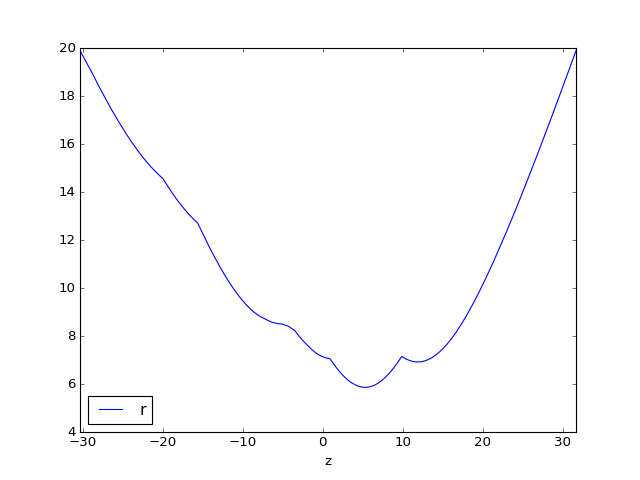

In [6]:
df_hole.plot(x='z',y='r')

## Isambard-based VdW profile

In [7]:
import sys
sys.path.append('/home/ba13026/mpmodeling/analysis/')
import isambard_dev
import radial_profile

**EXAMPLE**

In [8]:
p = isambard_dev.ampal.convert_pdb_to_ampal(param_list[0])
p_rad = radial_profile.RadialProfile(p)
data = p_rad.vdw('simple').T

df_isambard = pandas.DataFrame(data, columns=['z','r'])

<IPython.core.display.Javascript object>


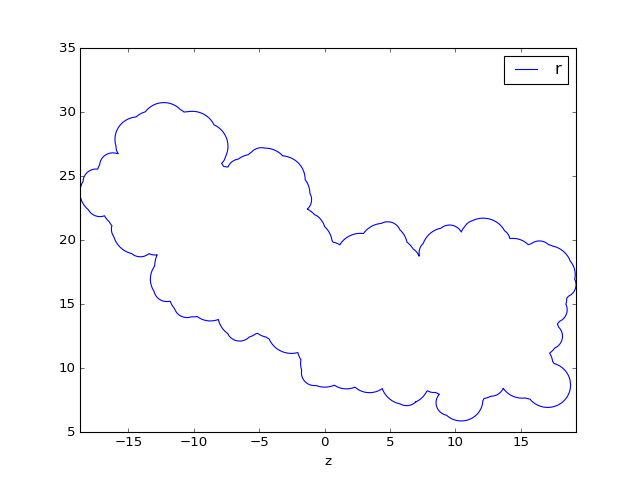

In [9]:
df_isambard.plot(x='z',y='r')

## Comparison between profiles

**SHOW SINGLE CHAIN**

<IPython.core.display.Javascript object>


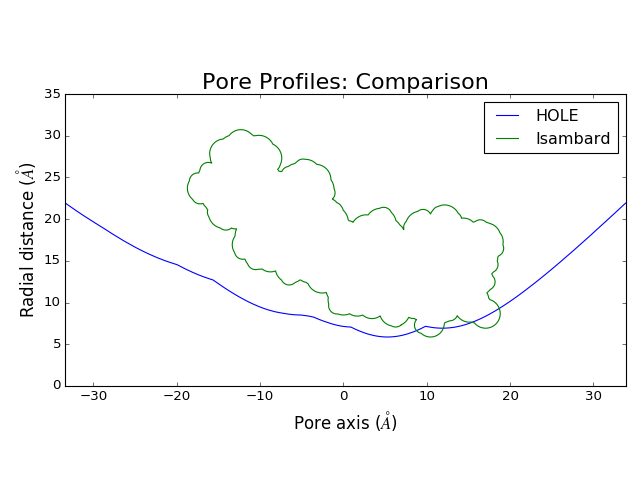

In [17]:
fig,ax = plt.subplots(1,1)

data = numpy.array(get_HOLE_profile(param_list[0],endrad)).T
df_hole = pandas.DataFrame(data, columns=['z','r'])
df_hole.plot(x='z',y='r',ax=ax,label='HOLE')

df_isambard.plot(x='z',y='r',ax=ax, label='Isambard')

ax.set_title("Pore Profiles: Comparison", fontsize=20)
ax.set_xlabel("Pore axis ($\AA$)", fontsize=15)
ax.set_ylabel("Radial distance ($\AA$)", fontsize=15)

ax.set_aspect('equal')
plt.tight_layout()
ax.set_ylim(0,35)
plt.show()

**SHOW TWO CHAINS FACING EACH OTHER**

<IPython.core.display.Javascript object>


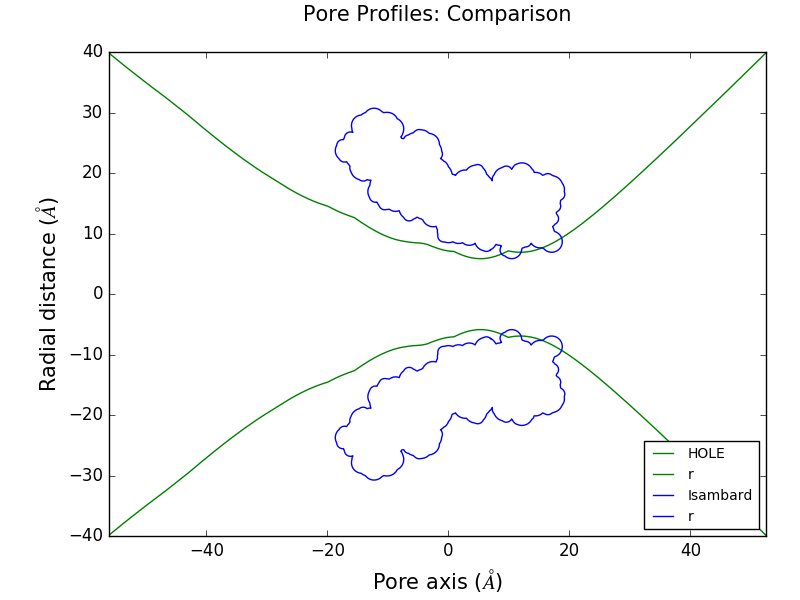

In [19]:
fig,ax = plt.subplots(1,1,dpi=100)

#################################
data = numpy.array(get_HOLE_profile(param_list[0],40)).T
df_hole = pandas.DataFrame(data, columns=['z','r'])

df_hole.plot(x='z',y='r',ax=ax,color='green',label='HOLE')
df_hole_reverse = pandas.DataFrame({
        'z':df_hole['z'],
        'r':df_hole['r'].apply(lambda x: x*-1)
        }
    )
df_hole_reverse.plot(x='z',y='r',color='green',ax=ax,legend=False)
#################################
df_isambard.plot(x='z',y='r',ax=ax,color='blue',label='Isambard')
df_isambard_reverse = pandas.DataFrame({
        'z':df_isambard['z'],
        'r':df_isambard['r'].apply(lambda x: x*-1)
        }
    )
df_isambard_reverse.plot(x='z',y='r',color='blue',ax=ax,legend=False)
#################################
ax.set_title("Pore Profiles: Comparison", fontsize=15, y=1.05)
ax.set_xlabel("Pore axis ($\AA$)", fontsize=15)
ax.set_ylabel("Radial distance ($\AA$)", fontsize=15)


# for i in range(0,len(df_hole),30):
#     circle = plt.Circle((df_hole.z[i], 0), df_hole.r[i], color='r',fill=False,alpha=0.3)
#     ax.add_artist(circle)
    
# for i in range(0,len(df_hole),30):
#     circle = plt.Circle((df_hole.z[i], 0), df_hole.r[i], color='black',fill=False)
#     ax.add_artist(circle)

ax.set_aspect('equal')
ax.set_ylim(-40,40)
ax.legend(fontsize=10,loc='lower right')
plt.tight_layout()
plt.show()

# Database Implementation

## Set up DB

In [ ]:
%%writefile /home/ba13026/mpmodeling/analysis/setup_db_metrics.py
import os
import sys
import json
from sqlalchemy import Column, ForeignKey, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
from sqlalchemy import create_engine

Base = declarative_base()

class Tags(Base):
    __tablename__ = 'tag'
    id = Column(Integer, primary_key=True) # SQL id 
    mutant = Column(String(250), nullable=False)
    group = Column(String(250), nullable=False)
    pdb_name = Column(String(250), nullable=False)
    frame = Column(String(250), nullable=False)

class Pore_Dimensions(Base):
    # Pore dimensions using HOLE and Isambard
    __tablename__ = 'pore_dimensions'
    id = Column(Integer, primary_key=True)
    #######################################
    pore_Rmin = Column(Float) # From HOLE
    pore_length = Column(Float) # From Isambard
    #######################################
    # Foreign key 
    tag_id = Column(Integer, ForeignKey('tag.id'))
    tag = relationship(Tags)
    
class Radii_of_Gyration(Base):
    # Pore dimensions using HOLE and Isambard
    __tablename__ = 'radii_of_gyration'
    id = Column(Integer, primary_key=True)
    #######################################
    Rg_x = Column(Float)
    Rg_y = Column(Float)
    Rg_z = Column(Float)
    #######################################
    # Foreign key 
    tag_id = Column(Integer, ForeignKey('tag.id'))
    tag = relationship(Tags)

if __name__ == "__main__":
    outdb = sys.argv[1] # Output name of database (.db)
    engine = create_engine('sqlite:///'+outdb)
    Base.metadata.create_all(engine)

## Insert data into DB

In [ ]:
%%writefile /home/ba13026/mpmodeling/analysis/insert2db_metrics.py
import sys
import os
import numpy
import operator
import subprocess
import json
import isambard_dev
import MDAnalysis as mda
import concurrent.futures
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

# Import modules from folder
modules_path = "/home/ba13026/mpmodeling/analysis/"
if modules_path not in sys.path:
    sys.path.append(modules_path)

import analyse_HOLE
from setup_db_metrics import Base, Tags, Pore_Dimensions, Radii_of_Gyration

def get_tags(model_pdb):
    idents = operator.itemgetter(*[0,1,2,-1])(model_pdb.split('/')[9:])
    mutant, group, model_name, frame = idents
    frame = frame[:-4]
    return mutant, group, model_name, frame
     
def get_Rg_components(model_pdb):
    try:
        u = mda.Universe(model_pdb)
        protein = u.select_atoms("protein")
        protein_mass = numpy.sum(protein.masses)
        protein_inertia = protein.moment_of_inertia() # tensor of inertia
        f = lambda x : numpy.sqrt(x/float(protein_mass))
        protein_Rg_n = [f(protein_inertia[i][i]) for i in range(3)]
        Rg_x, Rg_y, Rg_z = protein_Rg_n
        return Rg_x, Rg_y, Rg_z
    except:
        return 'Fail'

def get_HOLE_Rmin(model_pdb):
    dir_path = os.getcwd()
    tmp_wd = os.path.dirname(model_pdb)
    os.chdir(tmp_wd)
    try:
        HOLE_dimensions,HOLE_conductance_estimates = analyse_HOLE.hole(os.path.basename(model_pdb))
        os.chdir(dir_path)
        return HOLE_dimensions[0]
    except:
        os.chdir(dir_path)
        return 'Fail'
        
def get_channel_length(model_pdb):
    try:
        model_ampal = isambard_dev.ampal.convert_pdb_to_ampal(model_pdb)
        get_chain_Zcoords = lambda chain : [atom.z for atom in chain.get_atoms()]
        get_length = lambda chain : max(get_chain_Zcoords(chain)) - min(get_chain_Zcoords(chain))
        chains_lengths = list(map(get_length, model_ampal))
        return numpy.mean(chains_lengths)
    except:
        return 'Fail'

def process_model(n):
    model_pdb = param_list[n]
    #####################################
    # Model identifiers
    mutant, group, model_name, frame = get_tags(model_pdb)
    model_tags  = Tags(
                        mutant = mutant, 
                        group = group, 
                        pdb_name = model_name,
                        frame = frame
                        )
    session.add(model_tags)    
    #####################################
    # Radius of gyration decomposition
    data = get_Rg_components(model_pdb)
    model_Rgs = Radii_of_Gyration(
        Rg_x = data[0],
        Rg_y = data[1],
        Rg_z = data[2],
        tag  = model_tags
        )
    session.add(model_Rgs)
    #####################################
#     # Pore dimensions
    pore_Rmin = get_HOLE_Rmin(model_pdb)
    pore_length = get_channel_length(model_pdb)
    model_pore_dimensions = Pore_Dimensions(
        pore_Rmin = pore_Rmin,
        pore_length = pore_length,
        tag = model_tags
        )
    session.add(model_pore_dimensions)
    #####################################
    # COMMIT CHANGES TO DATABASE  
    session.commit()

#####################################
# Parallel Process Execution
def main():
    model_n = list(range(len(param_list)))
    with concurrent.futures.ProcessPoolExecutor(max_workers = ncores) as executor:
        executor.map(process_model, model_n)

if __name__ == '__main__':
    dbfile  = sys.argv[1] # Database filename
    param_json = sys.argv[2] # Dictionary with mutant structures info
    ncores = int(sys.argv[3]) # Number of cores

    # Extract info from dictionary
    with open(param_json, 'r') as fp:
        param_list = json.load(fp)
    fp.close()
    
    # Create engine and bind it to current session
    engine = create_engine('sqlite:///'+dbfile)
    Base.metadata.bind = engine
    DBSession = sessionmaker(bind=engine)
    session = DBSession()

    main()

## Terminal Execution

```bash
python ~/mpmodeling/analysis/setup_db_metrics.py conf_metrics_First10ns.db

nohup python ~/mpmodeling/analysis/insert2db_metrics.py conf_metrics_First10ns.db param_list_metrics_First10ns.json 30 > conf_metrics_First10ns.out &
```

In [ ]:
%%writefile /projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/md_relax/run_conf_metrics.sh
#!/bin/bash

python ~/mpmodeling/analysis/insert2db_metrics.py conf_metrics_classfied_docked.db param_list_metrics_classfied_docked.json 30 > conf_metrics_classfied_docked.out
wait

python ~/mpmodeling/analysis/insert2db_metrics.py conf_metrics_Last10ns.db param_list_metrics_Last10ns.json 30 > conf_metrics_Last10ns.out
wait

In [ ]:
!chmod +x /projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/md_relax/run_conf_metrics.sh

# Visualisation

In [1]:
wd = '/projects/s21/ba13026/Wza_Modeling/L-structures/rosetta/bg_test/md_relax/'

In [2]:
import os
import sys
import json
import pandas
import seaborn
import operator
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

# Import modules from folder
modules_path = "/home/ba13026/mpmodeling/analysis/"
if modules_path not in sys.path:
    sys.path.append(modules_path)

from setup_db_metrics import Base, Tags, Pore_Dimensions, Radii_of_Gyration

In [3]:
import random
import pandas as pd
import numpy
from scipy.stats import gaussian_kde
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from shapely.geometry.polygon import Polygon
from shapely.ops import cascaded_union
import matplotlib.pyplot as plt
%matplotlib notebook

def density_estimation(m1,m2):
    """Estimated data density from a contour map according to a Gaussian Kernel"""
    xmin=min(m1)
    xmax=max(m1)
    ymin=min(m2)
    ymax=max(m2)
    X, Y = numpy.mgrid[xmin:xmax:400j, ymin:ymax:400j]                                                     
    positions = numpy.vstack([X.ravel(), Y.ravel()])                                                       
    values = numpy.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = numpy.reshape(kernel(positions).T, X.shape)
    return X,Y,Z

def find_maxima(X1,X2):
    """Return the coordinates of the peaks of data density from a contour map"""
    X,Y,Z = list(density_estimation(X1,X2))
    # Find and filtre peaks by minimum pixel distance and fraction height glob-max
    coordinates = peak_local_max(Z, threshold_rel=0.5, min_distance=20)
    maxima = []
    for k in range(len(coordinates)):
        idx_0,idx_1 = coordinates[k]
        x_max, y_max = X[idx_0][0], Y[idx_0][idx_1]
        maxima.append((x_max, y_max))
    
    return maxima

def find_boundary_coords(contour_plot):
    """Return the coordinates of the boundary of the union of all closed contour lines"""
    polygons_list = []
    for l in range(len(contour_plot.allsegs)):
        prob = contour_plot.levels[l]
        for k in range(len(contour_plot.allsegs[l])):
            contour_plot_coords = contour_plot.allsegs[l][k]
            polygons_list.append(Polygon(contour_plot_coords))

    polygons_union = cascaded_union(polygons_list)
    polygons_union_boundary = numpy.array(list(polygons_union.boundary.coords)).T
    contour_plot_boundary = polygons_union_boundary
    
    return contour_plot_boundary

## Docked models

In [4]:
dbfile = wd+'conf_metrics_classfied_docked.db'

# Create engine and bind it to current session
engine = create_engine('sqlite:///'+dbfile)
Base.metadata.bind = engine
DBSession = sessionmaker(bind=engine)
session = DBSession()

In [5]:
TAGS = [
    ['cWza', 'conformation0'],
    ['cWza', 'conformation1'],
    ['cWza-K375C', 'conformation0'],
    ['cWza-K375C', 'conformation1'],
    ['cWza-S355C', 'conformation0'],
    ['cWza-S355C', 'conformation1'],
    ['cWza-Y373C', 'conformation1']
    ]

TAGS = [json.dumps(tag) for tag in TAGS]

### VdW dimensions

In [40]:
DFS = {}

for tag in TAGS:
    mutant, conformation = json.loads(tag)
    models_ids = session.query(Tags.id).filter_by(mutant=mutant,group=conformation).all()
    models_ids = [x[0] for x in models_ids]
    
    data = []
    for id in models_ids:
        x = session.query(Pore_Dimensions.pore_length).filter_by(id=id)[0][0]        
        y = session.query(Pore_Dimensions.pore_Rmin).filter_by(id=id)[0][0]
        data.append([x,y])
    ###########################################################    
    # Correct mislabeling
    ###########################################################
    if mutant == 'cWza-K375C' and conformation == 'conformation0':
        tag = json.dumps([mutant, 'conformation1'])
    elif mutant == 'cWza-K375C' and conformation == 'conformation1':
        tag = json.dumps([mutant, 'conformation0'])
    ###########################################################
    DFS[tag] = pandas.DataFrame(data,columns=['length','Rmin'])

#### Raw Data

<IPython.core.display.Javascript object>


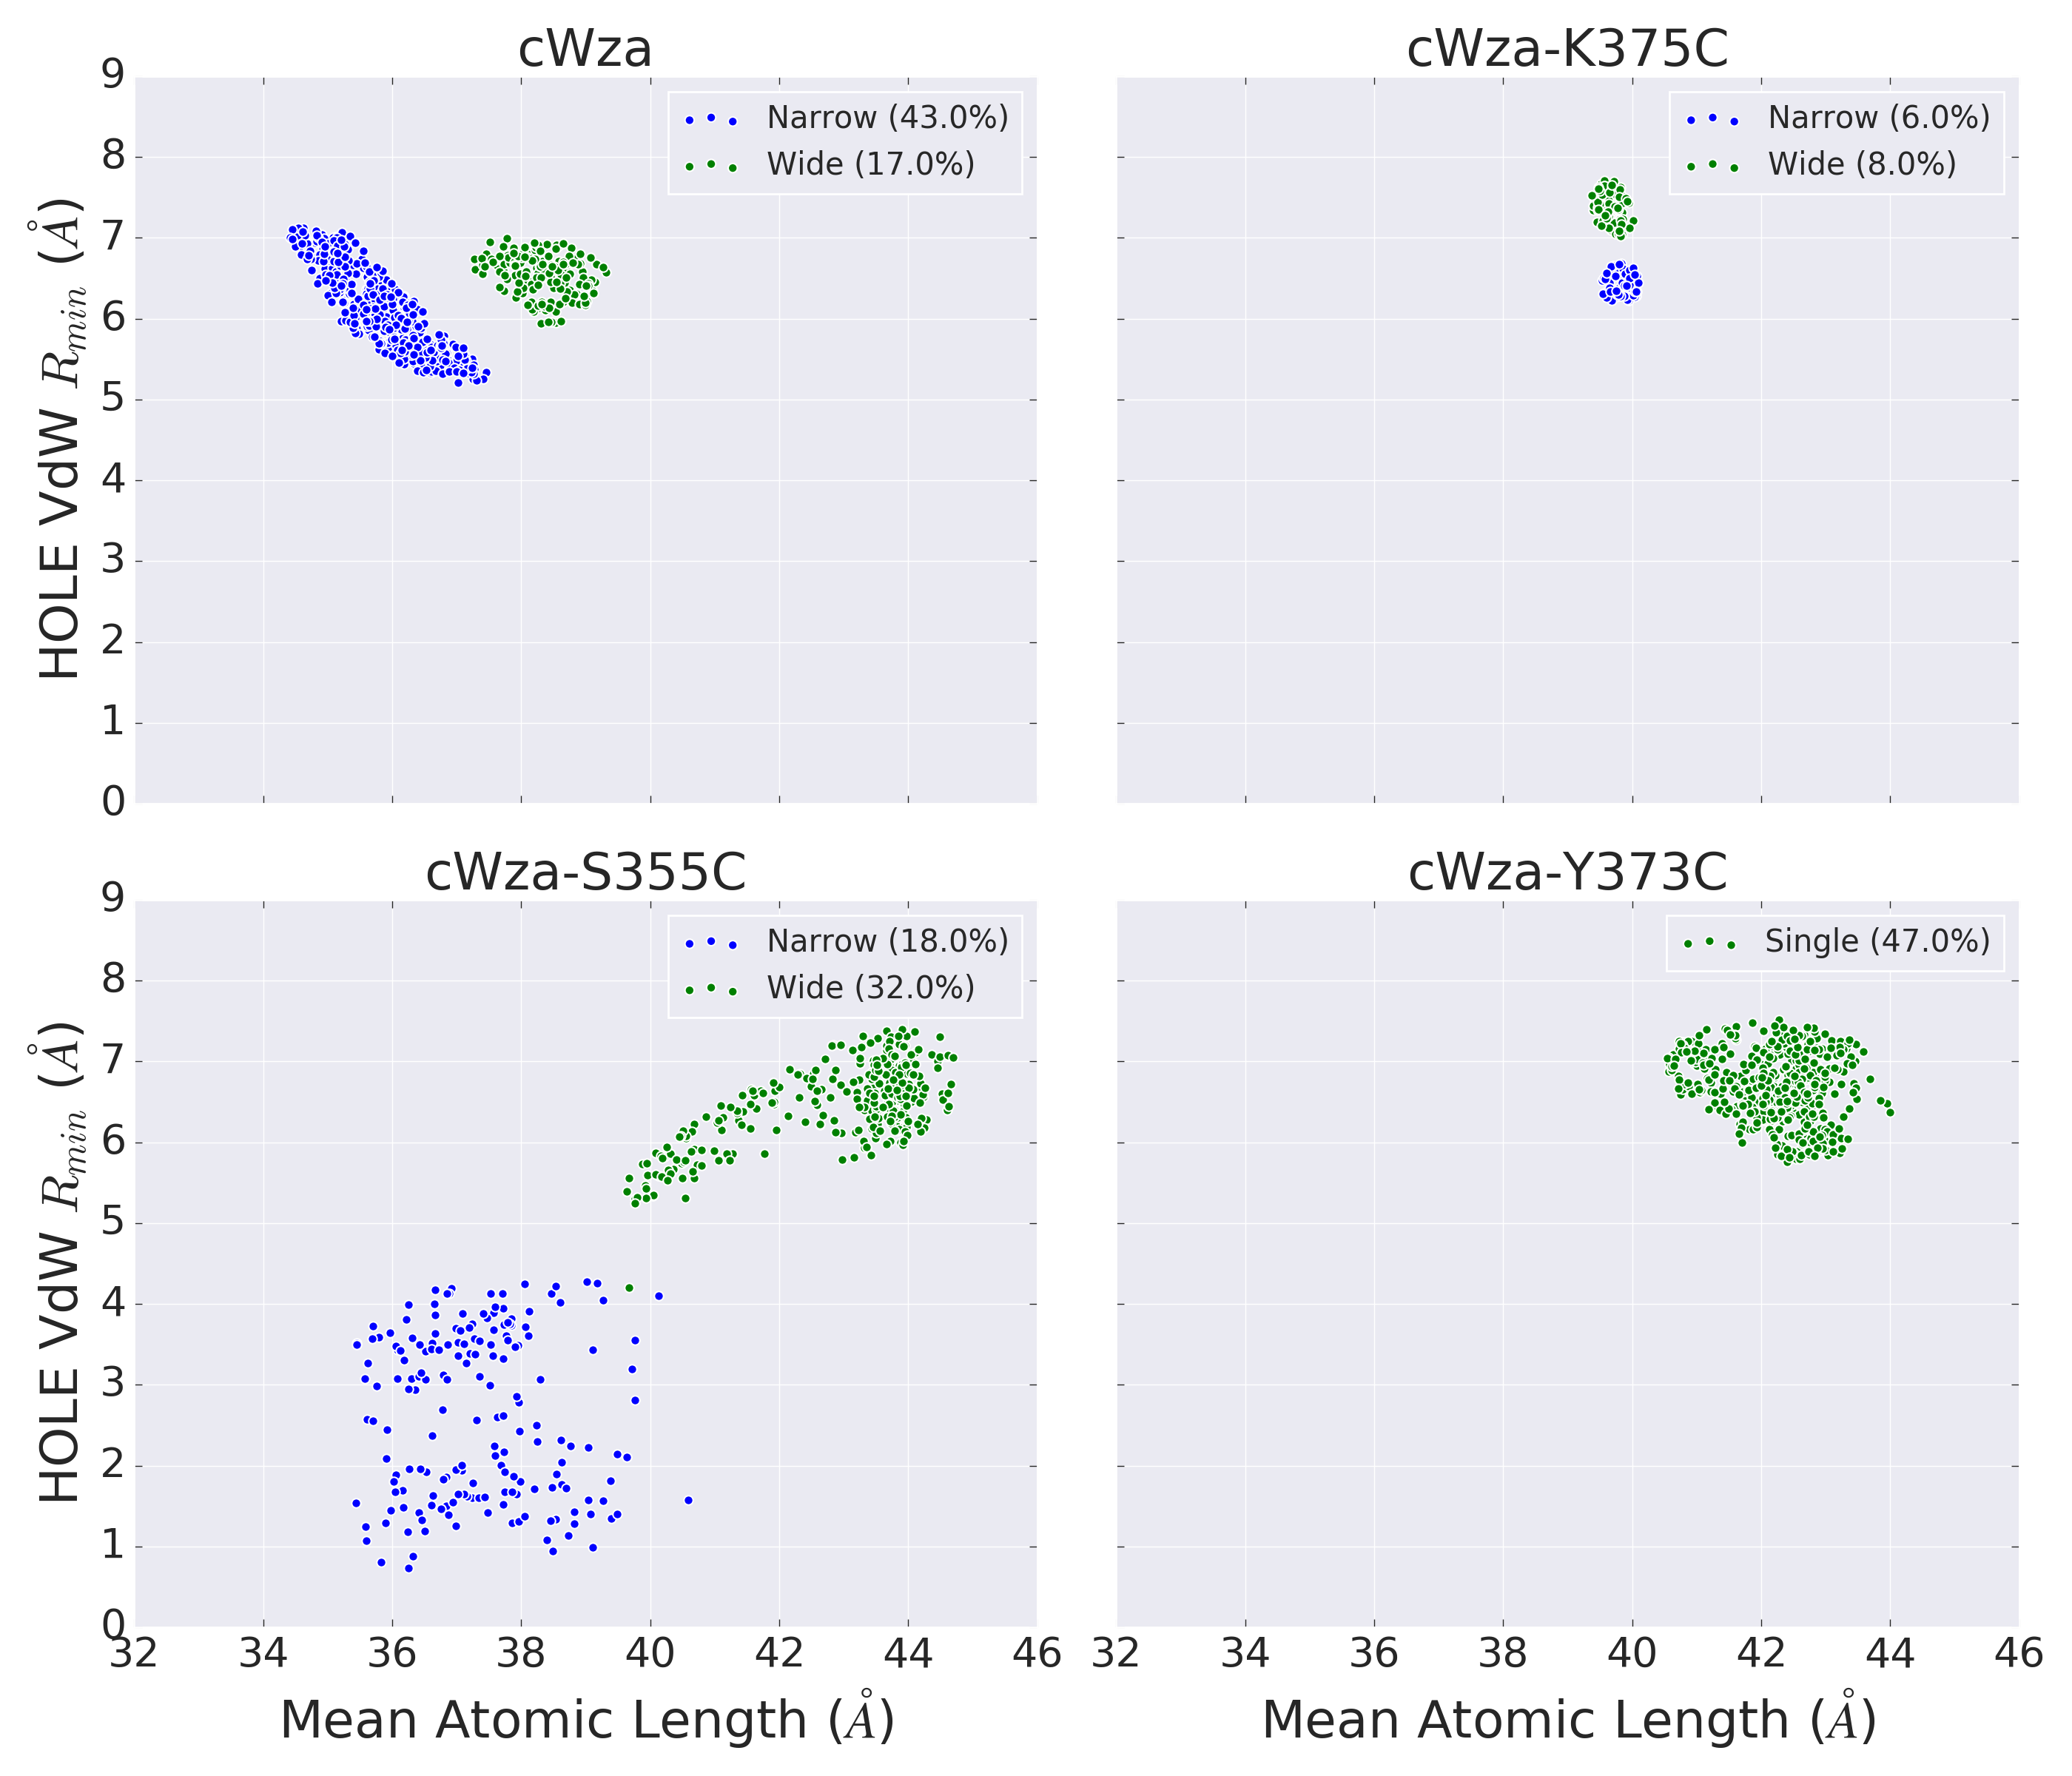

In [41]:
MUTANTS = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

CONFORMATIONS = {
    'cWza':['conformation0', 'conformation1'],
    'cWza-K375C':['conformation0', 'conformation1'],
    'cWza-S355C':['conformation0', 'conformation1'],
    'cWza-Y373C':['conformation1'],
}

fig, ax = plt.subplots(2,2,figsize=(14,12),sharex=True,sharey=True,dpi=200)
seaborn.set_style('darkgrid')

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

COLOURS = {
    'conformation0':'blue',
    'conformation1':'green'
}

for tag in TAGS:
    mutant,conformation = json.loads(tag)
    ###############################################
    # Label
    if mutant != 'cWza-Y373C' and conformation == 'conformation0':
        label = 'Narrow'
    elif mutant != 'cWza-Y373C' and conformation == 'conformation1':
        label = 'Wide'
    elif mutant == 'cWza-Y373C':
        label = 'Single'
    ###############################################
    N_models = 1000 #  Original number of docked models
    N_models_C = len(DFS[tag]) # Number of models per conformational group
    Percentage = numpy.floor(100*(N_models_C/N_models))
    ###############################################
    seaborn.scatterplot(
        x='length',
        y='Rmin',
        data=DFS[tag],
        color=COLOURS[conformation],
        label=label+' ('+str(Percentage)+'%)',
        ax=axes[mutant]
    )
    ###############################################                            
    # Customise plot
    ###############################################
    axes[mutant].set_title(mutant, fontsize=25)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    axes[mutant].set_xlabel("Mean Atomic Length ($\AA$)",fontsize=25)
    axes[mutant].set_ylabel("HOLE VdW $R_{min}$ ($\AA$)",fontsize=25)
    axes[mutant].legend(loc='best',fontsize=15)

plt.tight_layout()
plt.show()

#### Contour plots

<IPython.core.display.Javascript object>


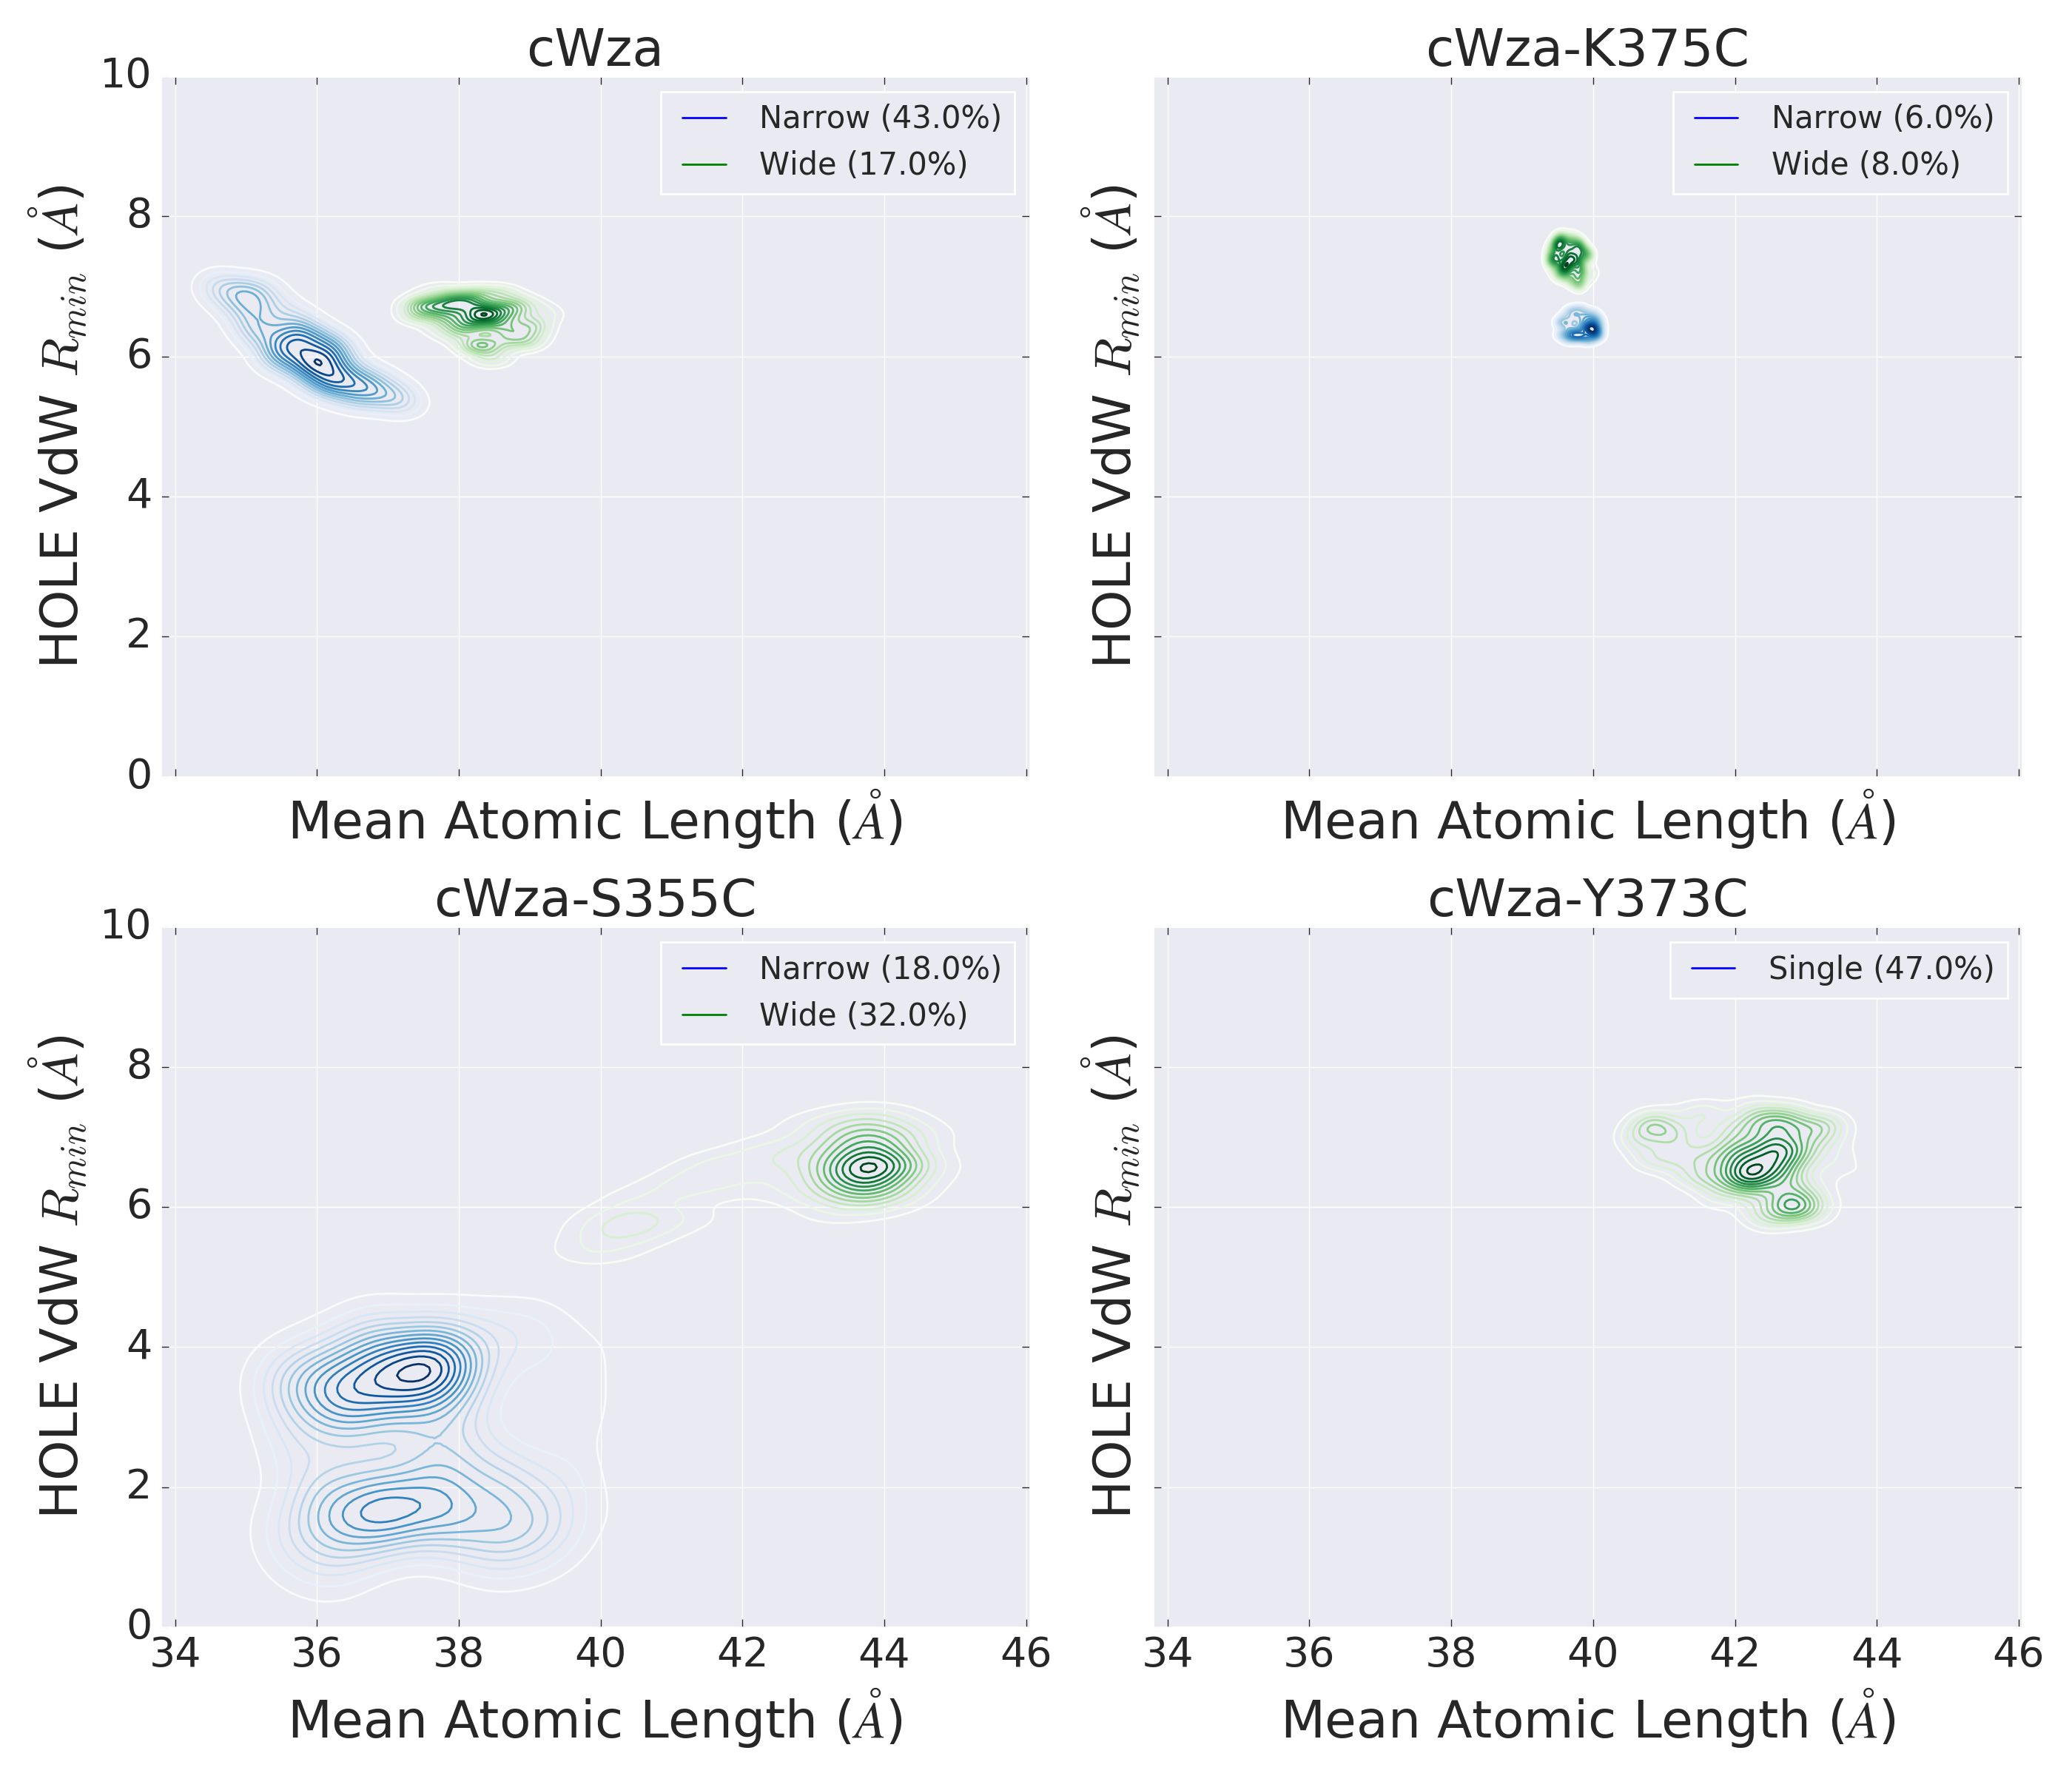

In [31]:
MUTANTS = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

CONFORMATIONS = {
    'cWza':['conformation0', 'conformation1'],
    'cWza-K375C':['conformation0', 'conformation1'],
    'cWza-S355C':['conformation0', 'conformation1'],
    'cWza-Y373C':['conformation1'],
}

fig, ax = plt.subplots(2,2,figsize=(14,12),sharex=True,sharey=True,dpi=200)
seaborn.set_style('darkgrid')

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

CMAPS = {
    'conformation0':'Blues',
    'conformation1':'Greens'
}

for tag in TAGS:
    mutant,conformation = json.loads(tag)
    ###############################################
    # Label
    if mutant != 'cWza-Y373C' and conformation == 'conformation0':
        label = 'Narrow'
    elif mutant != 'cWza-Y373C' and conformation == 'conformation1':
        label = 'Wide'
    elif mutant == 'cWza-Y373C':
        label = 'Single'
    ###############################################
    N_models = 1000 #  Original number of docked models
    N_models_C = len(DFS[tag]) # Number of models per conformational group
    Percentage = numpy.floor(100*(N_models_C/N_models))
    ###############################################
    seaborn.kdeplot(
            DFS[tag].length,
            DFS[tag].Rmin,
            n_levels=15,
            cmap=CMAPS[conformation],
            label=label+' ('+str(Percentage)+'%)',
            ax=axes[mutant]
    )
    ###############################################                            
    # Customise plot
    ###############################################
    axes[mutant].set_title(mutant, fontsize=25)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    axes[mutant].set_xlabel("Mean Atomic Length ($\AA$)",fontsize=25)
    axes[mutant].set_ylabel("HOLE VdW $R_{min}$ ($\AA$)",fontsize=25)
    axes[mutant].legend(loc='best',fontsize=15)
    axes[mutant].set_ylim(0,10)

plt.tight_layout()
plt.show()

### Radius of gyration

In [42]:
DFS = {}

for tag in TAGS:
    mutant, conformation = json.loads(tag)
    models_ids = session.query(Tags.id).filter_by(mutant=mutant,group=conformation).all()
    models_ids = [x[0] for x in models_ids]
    
    data = []
    for id in models_ids:
        x = session.query(Radii_of_Gyration.Rg_x).filter_by(id=id)[0][0]        
        y = session.query(Radii_of_Gyration.Rg_z).filter_by(id=id)[0][0]
        data.append([x,y])
    ###########################################################    
    # Correct mislabeling
    ###########################################################
    if mutant == 'cWza-K375C' and conformation == 'conformation0':
        tag = json.dumps([mutant, 'conformation1'])
    elif mutant == 'cWza-K375C' and conformation == 'conformation1':
        tag = json.dumps([mutant, 'conformation0'])
    ###########################################################
    DFS[tag] = pandas.DataFrame(data,columns=['Rg_x','Rg_z'])

#### Raw Data

<IPython.core.display.Javascript object>


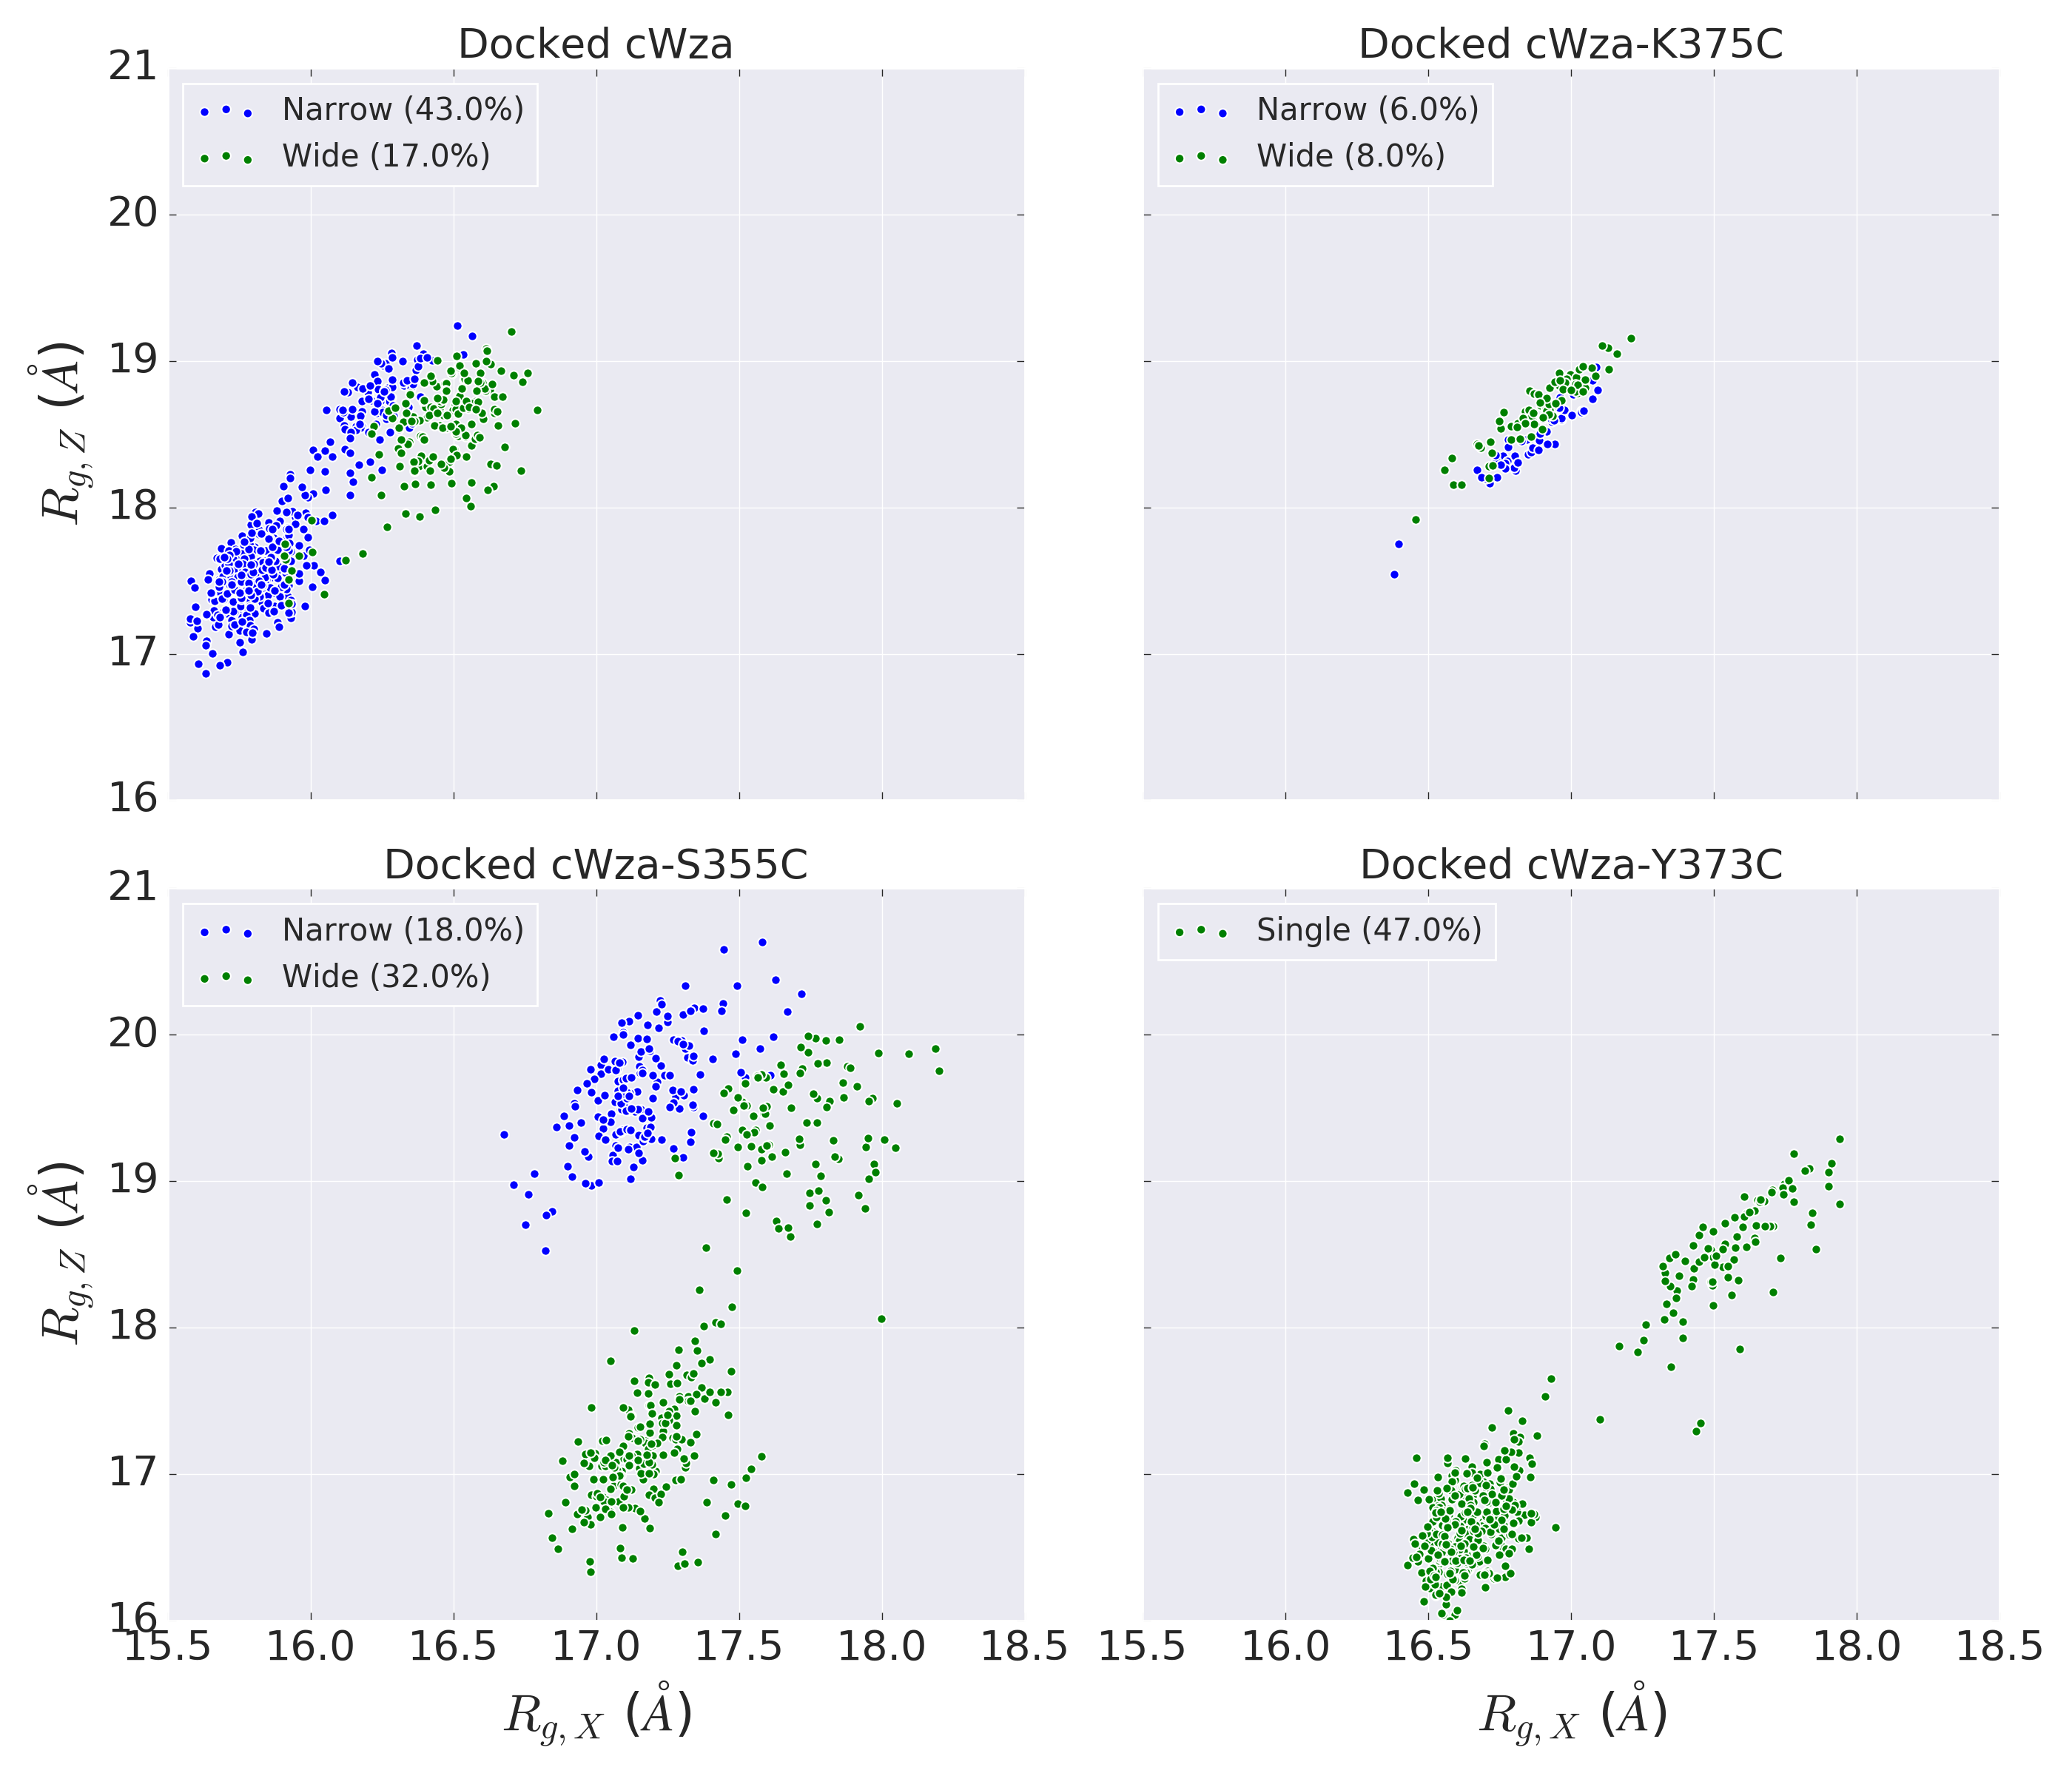

In [37]:
MUTANTS = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

CONFORMATIONS = {
    'cWza':['conformation0', 'conformation1'],
    'cWza-K375C':['conformation0', 'conformation1'],
    'cWza-S355C':['conformation0', 'conformation1'],
    'cWza-Y373C':['conformation1'],
}

fig, ax = plt.subplots(2,2,figsize=(14,12),sharex=True,sharey=True,dpi=200)
seaborn.set_style('darkgrid')

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

COLOURS = {
    'conformation0':'blue',
    'conformation1':'green'
}

for tag in TAGS:
    mutant,conformation = json.loads(tag)
    ###############################################
    # Label
    if mutant != 'cWza-Y373C' and conformation == 'conformation0':
        label = 'Narrow'
    elif mutant != 'cWza-Y373C' and conformation == 'conformation1':
        label = 'Wide'
    elif mutant == 'cWza-Y373C':
        label = 'Single'
    ###############################################
    N_models = 1000 #  Original number of docked models
    N_models_C = len(DFS[tag]) # Number of models per conformational group
    Percentage = numpy.floor(100*(N_models_C/N_models))
    ###############################################
    seaborn.scatterplot(
        x='Rg_x',
        y='Rg_z',
        data=DFS[tag],
        color=COLOURS[conformation],
        label=label+' ('+str(Percentage)+'%)',
        ax=axes[mutant]
    )
    ###############################################                            
    # Customise plot
    ###############################################
    axes[mutant].set_title("Docked "+mutant, fontsize=20)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    axes[mutant].set_xlabel("$R_{g,X}$ ($\AA$)",fontsize=25)
    axes[mutant].set_ylabel("$R_{g,Z}$ ($\AA$)",fontsize=25)
    axes[mutant].legend(loc='upper left',fontsize=15)
    axes[mutant].set_xlim(15.5,18.5)
    axes[mutant].set_ylim(16,21)

plt.tight_layout()
plt.show()

#### Contour plots

<IPython.core.display.Javascript object>


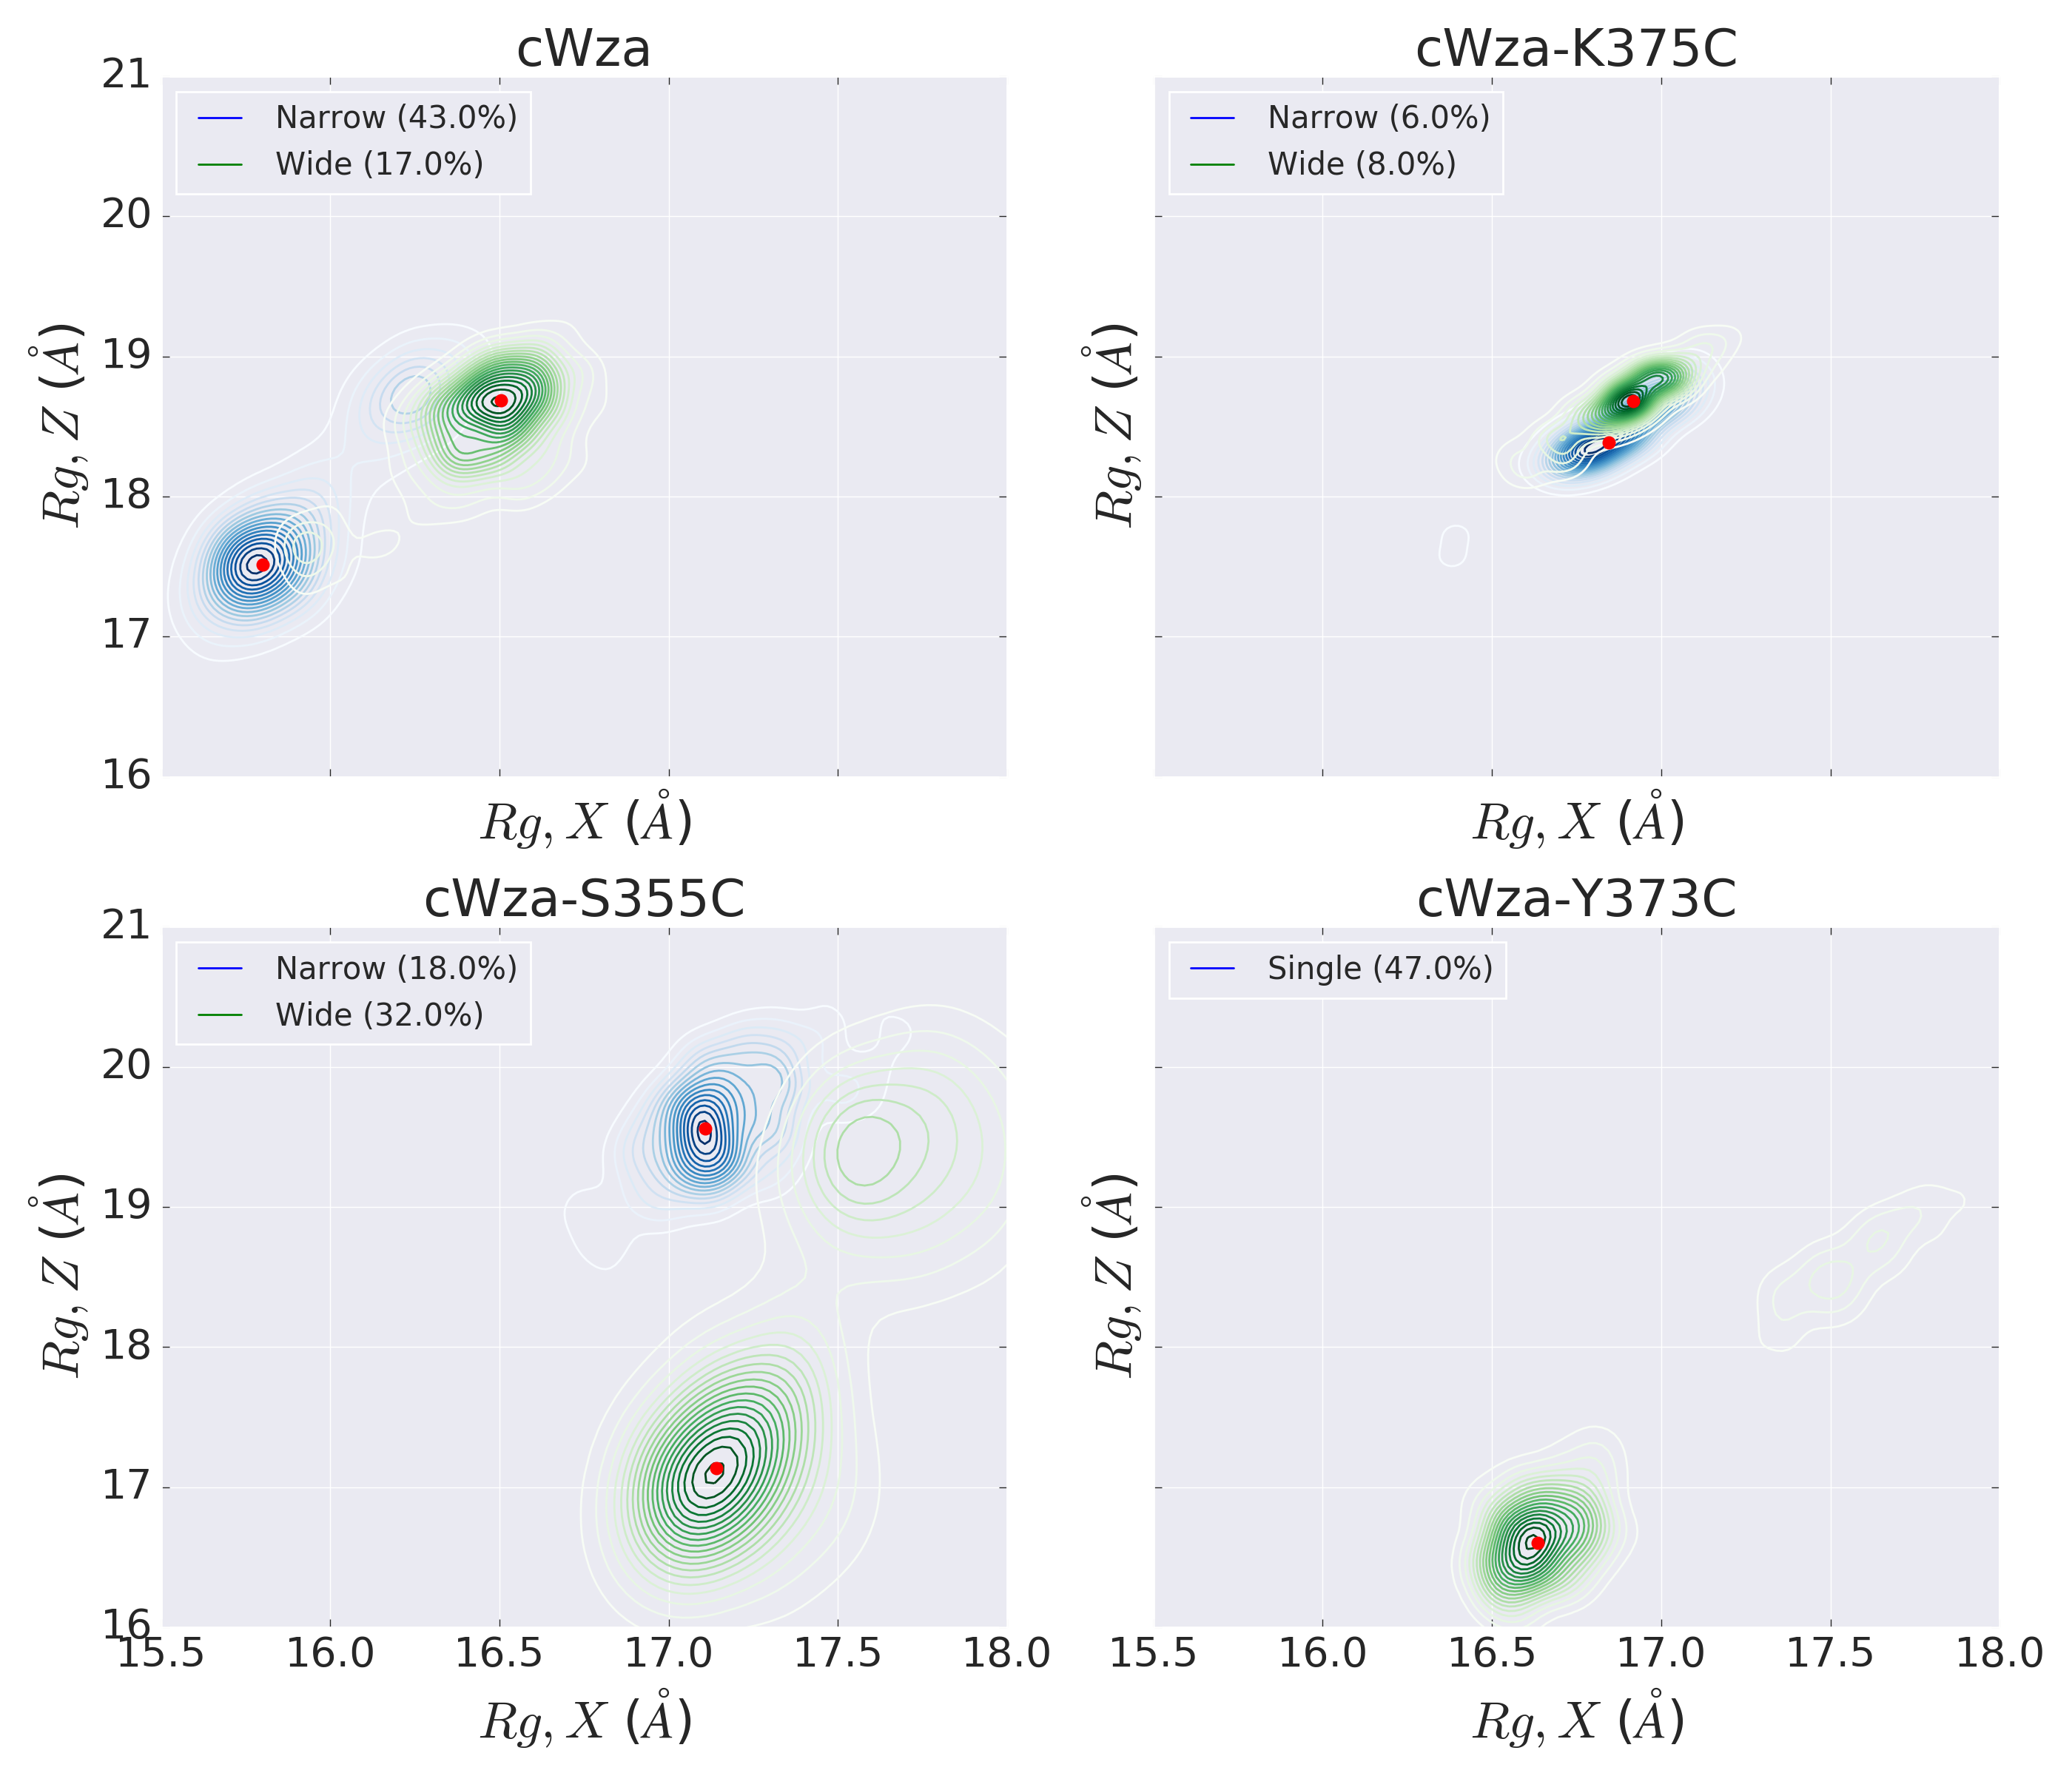

In [53]:
MUTANTS = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

CONFORMATIONS = {
    'cWza':['conformation0', 'conformation1'],
    'cWza-K375C':['conformation0', 'conformation1'],
    'cWza-S355C':['conformation0', 'conformation1'],
    'cWza-Y373C':['conformation1'],
}

fig, ax = plt.subplots(2,2,figsize=(14,12),sharex=True,sharey=True,dpi=200)
seaborn.set_style('darkgrid')

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

CMAPS = {
    'conformation0':'Blues',
    'conformation1':'Greens'
}

for tag in TAGS:
    mutant,conformation = json.loads(tag)
    ###############################################
    # Label
    if mutant != 'cWza-Y373C' and conformation == 'conformation0':
        label = 'Narrow'
    elif mutant != 'cWza-Y373C' and conformation == 'conformation1':
        label = 'Wide'
    elif mutant == 'cWza-Y373C':
        label = 'Single'
    ###############################################
    N_models = 1000 #  Original number of docked models
    N_models_C = len(DFS[tag]) # Number of models per conformational group
    Percentage = numpy.floor(100*(N_models_C/N_models))
    ###############################################
    seaborn.kdeplot(
            DFS[tag].Rg_x,
            DFS[tag].Rg_z,
            n_levels=20,
            cmap=CMAPS[conformation],
            label=label+' ('+str(Percentage)+'%)',
            ax=axes[mutant]
    )
    
#     for maximum in find_maxima(DFS[tag].Rg_x, DFS[tag].Rg_z):
#         x,y = maximum
#         axes[mutant].scatter(x,y,color='red',s=30,zorder=0)
    ###############################################                            
    # Customise plot
    ###############################################
    axes[mutant].set_title(mutant, fontsize=25)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    axes[mutant].set_xlabel("$R{g,X}$ ($\AA$)",fontsize=25)
    axes[mutant].set_ylabel("$R{g,Z}$ ($\AA$)",fontsize=25)
    axes[mutant].legend(loc='upper left',fontsize=15)
    axes[mutant].set_xlim(15.5,18)
    axes[mutant].set_ylim(16,21)

for tag in TAGS:
    mutant,conformation = json.loads(tag)
    for maximum in find_maxima(DFS[tag].Rg_x, DFS[tag].Rg_z):
        x,y = maximum
        axes[mutant].scatter(x,y,color='red',s=30,zorder=4)

plt.tight_layout()
plt.show()

In [54]:
session.close_all()

## MD simulation of docked models

In [24]:
# dbfile_First10ns = wd+'conf_metrics_First10ns.db'
dbfile = wd+'conf_metrics_Last10ns.db'

# Create engine and bind it to current session
engine = create_engine('sqlite:///'+dbfile)
Base.metadata.bind = engine
DBSession = sessionmaker(bind=engine)
session = DBSession()

In [25]:
TAGS = [
    ['cWza', 'conformation0'],
    ['cWza', 'conformation1'],
    ['cWza-K375C', 'conformation0'],
    ['cWza-K375C', 'conformation1'],
    ['cWza-S355C', 'conformation0'],
    ['cWza-S355C', 'conformation1'],
    ['cWza-Y373C', 'conformation1']
    ]

TAGS = [json.dumps(tag) for tag in TAGS]

### Check integrity of DB

FIRST **Check for redundancies in parameter list**

In [23]:
with open(wd+'param_list_metrics_Last10ns.json', 'r') as fp:
    param_list = json.load(fp)
fp.close()

If both values are identical, the list has no redundancies. `set()` removes redundant items in list.

In [38]:
len(param_list), len(list(set(param_list)))

(28100, 28100)

SECOND **Check if all files in list exist**

In [39]:
COUNTER = 0
for f in param_list:
    if not os.path.isfile(f):
        COUNTER +=1

If `COUNTER` is zero, then all files exist. This indicates that frame extraction from MD trajectories was successful.

In [40]:
COUNTER

0

THIRD **Check that all frames have been assigned an ID in the database**

In [43]:
COUNTER = 0
model_pdb_NoID = []
for model_pdb in param_list:
    idents = operator.itemgetter(*[0,1,2,-1])(model_pdb.split('/')[9:])
    mutant, group, model_name, frame = idents
    frame = frame[:-4]
    frame_id = session.query(Tags.id).filter_by(
                                            mutant = mutant,
                                            group = conformation,
                                            pdb_name = model_name,
                                            frame = frame
                                            ).all()
    if len(frame_id) == 0:
        COUNTER +=1
        model_pdb_NoID.append(model_pdb)

From this number we can identify the percentage (%) models were not considered for the DB

In [47]:
100*COUNTER/len(param_list)

97.76512455516014

<span style="color:blue">**EXPLANATION**</span>

Extraction of HOLE data was attempted before HOLE finished when called by `subprocess` in script `~/mpanalisys/analysis/analyse_HOLE.py`.

SOLUTION: Used the `.wait()` property of `subprocess.Popen` process right before attempting data extraction.

### VdW dimensions

In [29]:
DFS = {}
COUNTER = 0
for tag in TAGS:
    mutant, conformation = json.loads(tag)
    models_ids = session.query(Tags.id).filter_by(mutant=mutant,group=conformation).all()
    models_ids = [x[0] for x in models_ids]
    COUNTER = COUNTER + len(models_ids)
    
    data = []
    for id in models_ids:
        x = session.query(Pore_Dimensions.pore_length).filter_by(id=id)[0][0]        
        y = session.query(Pore_Dimensions.pore_Rmin).filter_by(id=id)[0][0]
        data.append([x,y])

    DFS[tag] = pandas.DataFrame(data,columns=['length','Rmin'])

In [30]:
COUNTER

1130

#### Raw Data

<IPython.core.display.Javascript object>


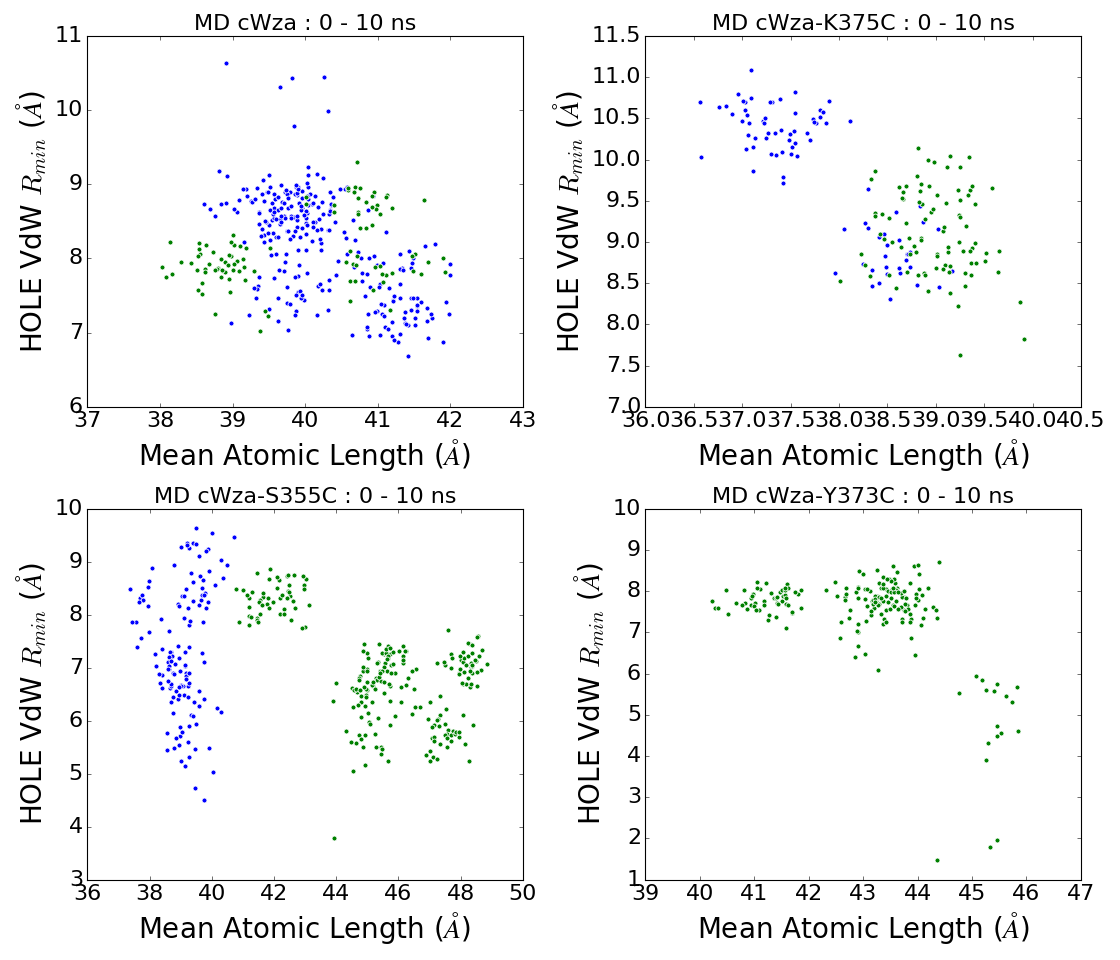

In [7]:
MUTANTS = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

CONFORMATIONS = {
    'cWza':['conformation0', 'conformation1'],
    'cWza-K375C':['conformation0', 'conformation1'],
    'cWza-S355C':['conformation0', 'conformation1'],
    'cWza-Y373C':['conformation1'],
}

fig, ax = plt.subplots(2,2,figsize=(14,12))
seaborn.set_style('darkgrid')

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

COLOURS = {
    'conformation0':'blue',
    'conformation1':'green'
}

for tag in TAGS:
    mutant,conformation = json.loads(tag)
    seaborn.scatterplot(
        x='length',
        y='Rmin',
        data=DFS[tag],
        color=COLOURS[conformation],
        ax=axes[mutant]
    )
    ###############################################                            
    # Customise plot
    ###############################################
    axes[mutant].set_title("MD "+mutant+' : 0 - 10 ns', fontsize=20)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    axes[mutant].set_xlabel("Mean Atomic Length ($\AA$)",fontsize=25)
    axes[mutant].set_ylabel("HOLE VdW $R_{min}$ ($\AA$)",fontsize=25)

plt.tight_layout()
plt.show()

#### Contour plots

<IPython.core.display.Javascript object>


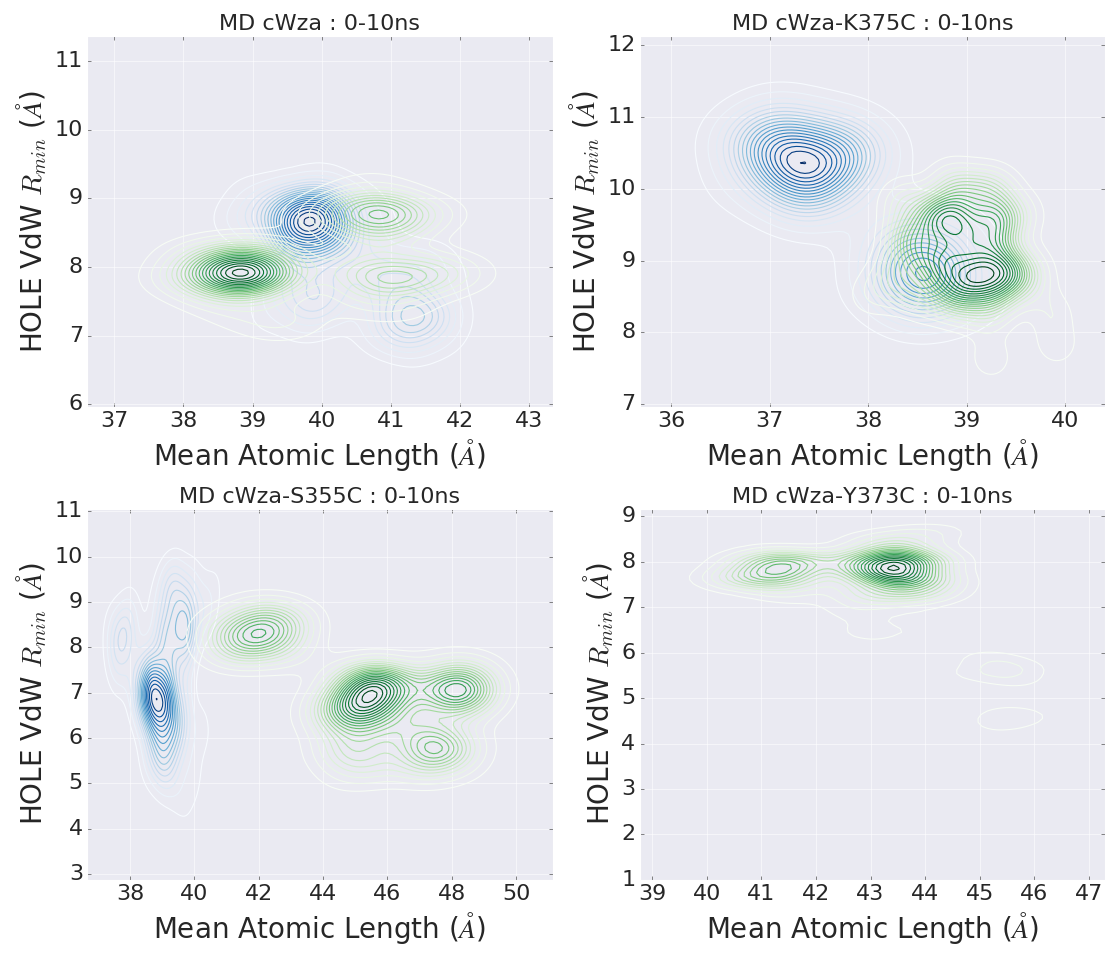

In [8]:
MUTANTS = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

CONFORMATIONS = {
    'cWza':['conformation0', 'conformation1'],
    'cWza-K375C':['conformation0', 'conformation1'],
    'cWza-S355C':['conformation0', 'conformation1'],
    'cWza-Y373C':['conformation1'],
}

fig, ax = plt.subplots(2,2,figsize=(14,12))
seaborn.set_style('darkgrid')

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

CMAPS = {
    'conformation0':'Blues',
    'conformation1':'Greens'
}

for tag in TAGS:
    mutant,conformation = json.loads(tag)
    seaborn.kdeplot(
            DFS[tag].length,
            DFS[tag].Rmin,
            n_levels=20,
            cmap=CMAPS[conformation],
            ax=axes[mutant]
    )
    
#     DFS[tag].plot(x='length',y='Rmin',kind='scatter',ax=axes[mutant])

#         for maximum in find_maxima(X1, X2):
#             x,y = maximum
#             axes[mutant].scatter(x,y,color='red',zorder=1)
    ###############################################                            
    # Customise plot
    ###############################################
    axes[mutant].set_title("MD "+mutant+' : 0-10ns', fontsize=20)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    axes[mutant].set_xlabel("Mean Atomic Length ($\AA$)",fontsize=25)
    axes[mutant].set_ylabel("HOLE VdW $R_{min}$ ($\AA$)",fontsize=25)

plt.tight_layout()
plt.show()

### Radius of gyration

In [9]:
DFS = {}

for tag in TAGS:
    mutant, conformation = json.loads(tag)
    models_ids = session.query(Tags.id).filter_by(mutant=mutant,group=conformation).all()
    models_ids = [x[0] for x in models_ids]
    
    data = []
    for id in models_ids:
        x = session.query(Radii_of_Gyration.Rg_x).filter_by(id=id)[0][0]        
        y = session.query(Radii_of_Gyration.Rg_z).filter_by(id=id)[0][0]
        data.append([x,y])

    DFS[tag] = pandas.DataFrame(data,columns=['Rg_x','Rg_z'])

#### Raw Data

<IPython.core.display.Javascript object>


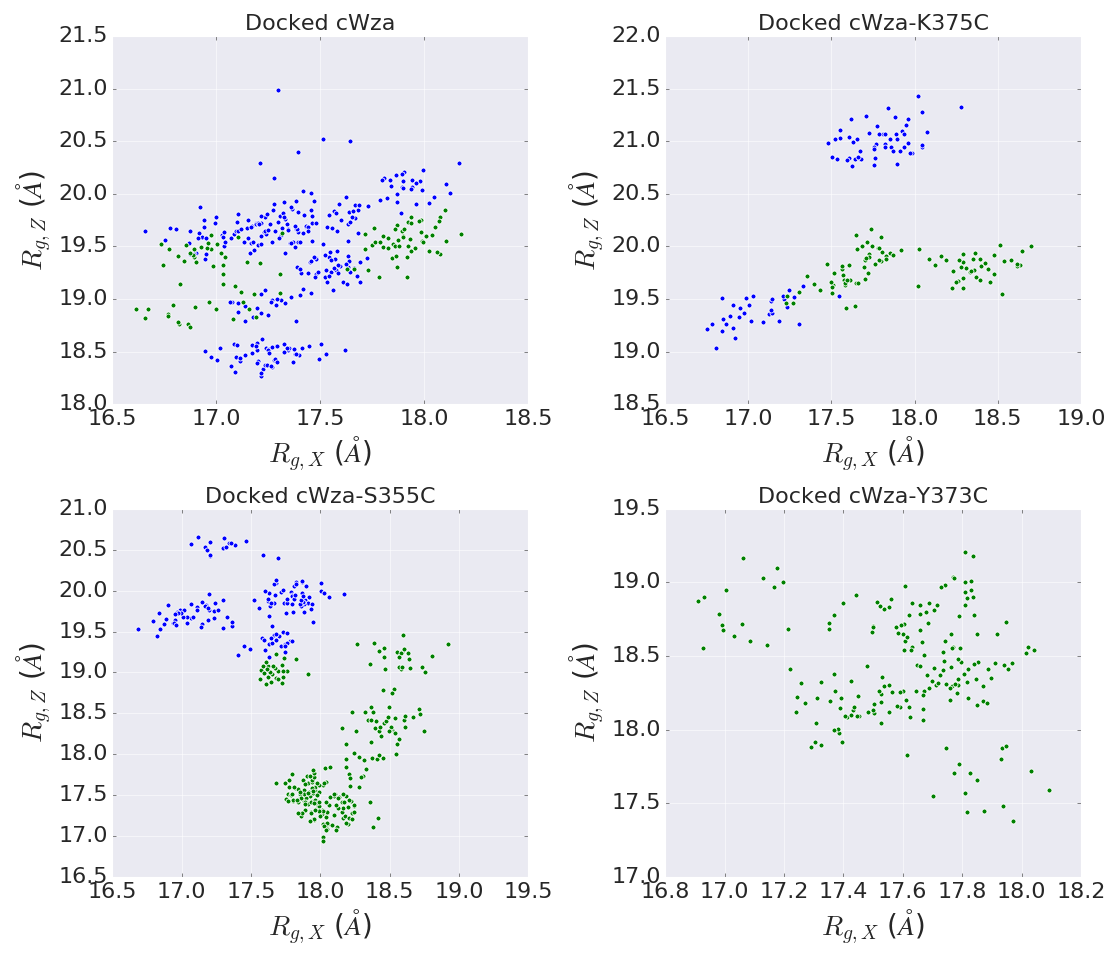

In [10]:
MUTANTS = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

CONFORMATIONS = {
    'cWza':['conformation0', 'conformation1'],
    'cWza-K375C':['conformation0', 'conformation1'],
    'cWza-S355C':['conformation0', 'conformation1'],
    'cWza-Y373C':['conformation1'],
}

fig, ax = plt.subplots(2,2,figsize=(14,12))
seaborn.set_style('darkgrid')

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

COLOURS = {
    'conformation0':'blue',
    'conformation1':'green'
}

for tag in TAGS:
    mutant,conformation = json.loads(tag)
    seaborn.scatterplot(
        x='Rg_x',
        y='Rg_z',
        data=DFS[tag],
        color=COLOURS[conformation],
        ax=axes[mutant]
    )
    ###############################################                            
    # Customise plot
    ###############################################
    axes[mutant].set_title("Docked "+mutant, fontsize=20)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    axes[mutant].set_xlabel("$R_{g,X}$ ($\AA$)",fontsize=25)
    axes[mutant].set_ylabel("$R_{g,Z}$ ($\AA$)",fontsize=25)

plt.tight_layout()
plt.show()

#### Contour plots

<IPython.core.display.Javascript object>


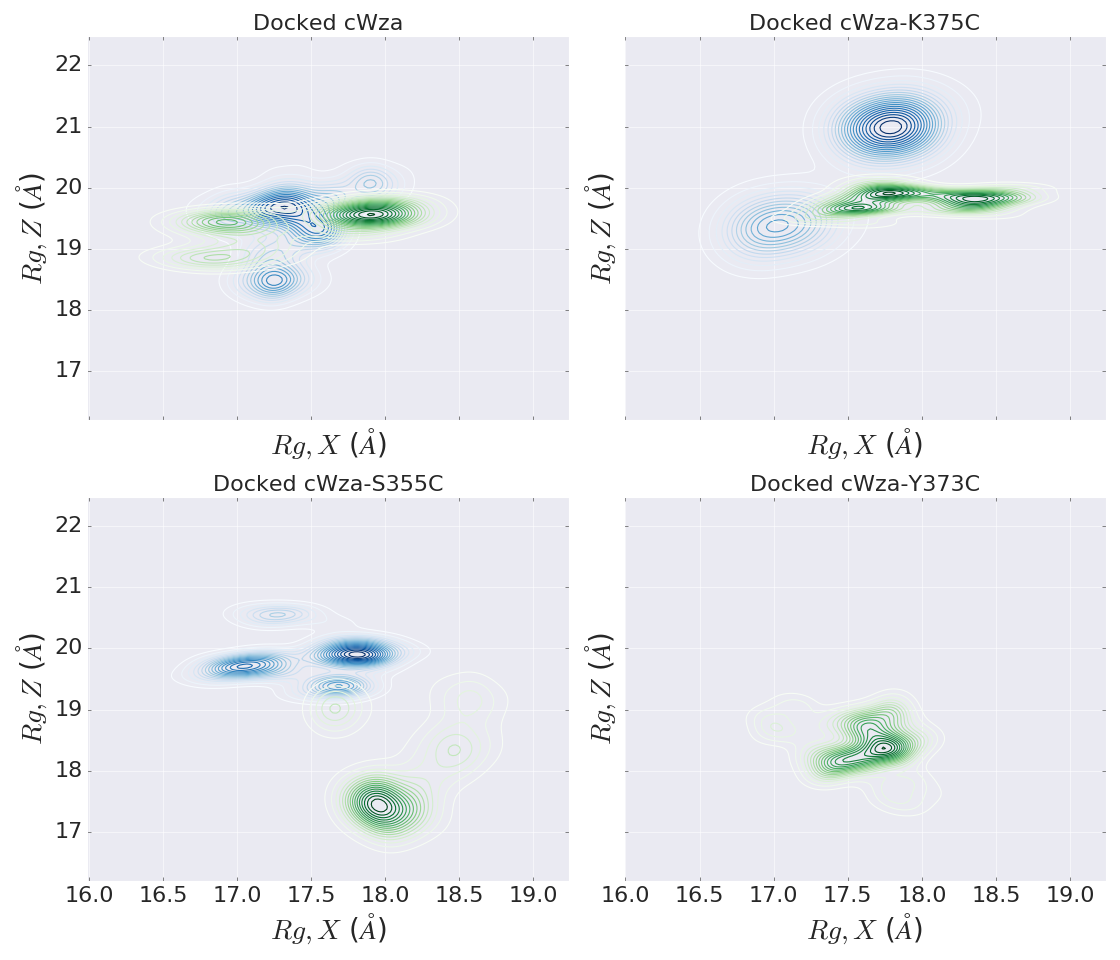

In [12]:
MUTANTS = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

CONFORMATIONS = {
    'cWza':['conformation0', 'conformation1'],
    'cWza-K375C':['conformation0', 'conformation1'],
    'cWza-S355C':['conformation0', 'conformation1'],
    'cWza-Y373C':['conformation1'],
}

fig, ax = plt.subplots(2,2,figsize=(14,12),sharex=True,sharey=True)
seaborn.set_style('darkgrid')

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

CMAPS = {
    'conformation0':'Blues',
    'conformation1':'Greens'
}

for tag in TAGS:
    mutant,conformation = json.loads(tag)
    seaborn.kdeplot(
            DFS[tag].Rg_x,
            DFS[tag].Rg_z,
            n_levels=20,
            cmap=CMAPS[conformation],
            ax=axes[mutant]
    )
    
#     for maximum in find_maxima(DFS[tag].Rg_x, DFS[tag].Rg_z):
#         x,y = maximum
#         axes[mutant].scatter(x,y,color='red',zorder=1)
    ###############################################                            
    # Customise plot
    ###############################################
    axes[mutant].set_title("Docked "+mutant, fontsize=20)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    axes[mutant].set_xlabel("$R{g,X}$ ($\AA$)",fontsize=25)
    axes[mutant].set_ylabel("$R{g,Z}$ ($\AA$)",fontsize=25)

plt.tight_layout()
plt.show()

In [ ]:
MUTANTS = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

CONFORMATIONS = {
    'cWza':['conformation0', 'conformation1'],
    'cWza-K375C':['conformation0', 'conformation1'],
    'cWza-S355C':['conformation0', 'conformation1'],
    'cWza-Y373C':['conformation1'],
}

fig, ax = plt.subplots(2,2,figsize=(14,12))
seaborn.set_style('darkgrid')

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

CMAPS = {
    'conformation0':'Blues',
    'conformation1':'Greens'
}

for i in range(len(MUTANTS)):
    mutant = MUTANTS[i]
    for C in CONFORMATIONS[mutant]:
        X1 = []
        X2 = []
        mutant_dir = mutant+'/'+C 
        for model_dir in [mutant_dir+'/'+model for model in os.listdir(wd+mutant_dir)]:
            model_name = model_dir.split('/')[-1]
            model_pdb = wd+'/'+model_dir+'/'+model_name+'.pdb'
            Rg_x, Rg_y, Rg_z = get_Rg_components(model_pdb)
            X1.append(Rg_x)
            X2.append(Rg_z)
        seaborn.kdeplot(X1,X2,n_levels=20,cmap=CMAPS[C],ax=axes[mutant],zorder=0)
        for maximum in find_maxima(X1, X2):
            x,y = maximum
            axes[mutant].scatter(x,y,color='red',zorder=1)
    ###############################################                            
    # Customise plot
    ###############################################
    axes[mutant].set_title("Docked "+mutant+": Whole Conformational Group", fontsize=15)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    axes[mutant].set_xlabel("$R_g$",fontsize=25)
    axes[mutant].set_ylabel("$R_g$",fontsize=25)

plt.tight_layout()
plt.show()

**Customised Layout**

In [ ]:
fig, ax = plt.subplots(1,1)

Colours = ['blue','green','red']
for i in range(len(DATA)):
    XY = DATA[i]
    X1,X2 = XY[0],XY[1]
    Xc,Yc,Zc = list( density_estimation(X1,X2) )
    contour_plot = ax.contour(Xc,Yc,Zc,20,colors='k',alpha=0.05)
    contour_plot_boundary = find_boundary_coords(contour_plot)  

    ax.fill(*contour_plot_boundary,color=Colours[i],alpha=0.2,zorder=0)

    for maximum in find_maxima(X1, X2):
        x,y = maximum
        ax.scatter(x,y,color=Colours[i],zorder=1)

ax.set_title("Overlapping Transparent Contour Plots")
ax.set_xlabel("X")
ax.set_ylabel("Y")

plt.show()

# Other Implementations

## Make Movie

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * len(x))
    return line,


def animate(i):
    line.set_ydata(np.sin(x + i / 100))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, init_func=init, interval=2, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# from matplotlib.animation import FFMpegWriter
# writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

## Radius of Gyration: `MDAnalysis`

### Single PDB

In [ ]:
import MDAnalysis as mda

def get_Rg_components(model_pdb):
    u = mda.Universe(model_pdb)
    protein = u.select_atoms("protein")
    protein_mass = numpy.sum(protein.masses)
    protein_inertia = protein.moment_of_inertia() # tensor of inertia
    f = lambda x : numpy.sqrt(x/float(protein_mass))
    protein_Rg_n = [f(protein_inertia[i][i]) for i in range(3)]
    Rg_x, Rg_y, Rg_z = protein_Rg_n
    return Rg_x, Rg_y, Rg_z

In [ ]:
get_Rg_components(model_pdb)

### MD trajectory

In [ ]:
import os
import numpy
import MDAnalysis as mda

def is_traj_available(dir_path, md_name):
    """Check whether all trajectory files are available
    This indicates whether simulations has finished successfully too"""
    gro_path = dir_path + name + ".gro"
    tpr_path = dir_path + name + ".tpr"
    xtc_path = dir_path + name + ".xtc"
    test_files = [gro_path, tpr_path, xtc_path]
    if all(map(os.path.isfile, test_files)):
        return True

def get_Rg_components_traj(dir_path, md_name):
    if is_traj_available(dir_path, md_name):
        tpr_path = dir_path + name + ".tpr"
        xtc_path = dir_path + name + ".xtc"
        u = mda.Universe(tpr_path, xtc_path, in_memory=True)
        n_frames = u.trajectory.n_frames
        dt = u.trajectory.dt
        mssg = "Loaded "+str(n_frames)+" frames with timestep "+str(dt)
#         print(mssg)
    else:
        print("MD traj files (.tpr/.xtc) not available")
    try:
        protein = u.select_atoms("protein", updating=True)
        data = []
        for ts in u.trajectory:
            protein_mass = numpy.sum(protein.masses)
            protein_inertia = protein.moment_of_inertia() # tensor of inertia
            protein_mass = numpy.sum(protein.masses)
            protein_inertia = protein.moment_of_inertia() # tensor of inertia
            f = lambda x : numpy.sqrt(x/float(protein_mass))
            protein_Rg_n = [f(protein_inertia[i][i]) for i in range(3)]
            Rg_x, Rg_y, Rg_z = protein_Rg_n
            data.append([Rg_x, Rg_y, Rg_z])
        return data
    except:
        return []
    try:
        u.close()
    except:
        pass

In [ ]:
mutant = 'cWza-K375C'
C = 'conformation0'
model_dir = mutant+'/'+C 
model_name = 'refined1_0001_INPUT_0900_ignorechain'

In [ ]:
name = "md_100ns"
dir_path = wd + model_dir+ '/' +model_name+'/complex/mdf/'

In [ ]:
if is_traj_available(dir_path, name):
    Rg_traj = get_Rg_components_traj(dir_path, name)

# NOTES



* <b><span style="color:red"> NOTE </span></b> `isambard` does not have a way to compute the components of $R_g$

* Reference: Moment of Inertia

> https://en.wikipedia.org/wiki/Moment_of_inertia#Inertia_tensor

> https://www.mdanalysis.org/MDAnalysisTutorial/atomgroups.html

**About HOLE**

* HOLE wrapper implemented with `MDAnalysis`
* Needs HOLE to be compiled and located in `~/hole2/exe/hole`, although can be modified.

https://www.mdanalysis.org/docs/documentation_pages/analysis/hole.html

HOLE <span style="color:red">Execution: 30 mins</span> for single trajectory of 100 frames

<span style="color:red">ISSUE</span>: 
* Need to create soft link to PDB to avoid HOLE from crashing due to long path name.
* `MDAnalysis` already implements this solution.
* HOLE implementation of MDAnalysis cannot be implemented in parallel

NOTES:

* Had to modify time length of trajectory to analyse (`0-100000 # (=100ns) ps`)
* Also, modified timestep of frames for extraction (`dt=100 # ps`)